In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sys.path.append('../')

In [7]:
import datatools

In [8]:
import importlib

In [9]:
from glob import glob

## Load Data

In [10]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
DATA_LOC=f"{SIM}/stgc/atlas_nsw_pad_z0_stgc20Max1_bkgr_1_CovAngle_TRAIN/*.h5"

files=glob(DATA_LOC)

print(len(files))

135


In [11]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 135/135 [00:04<00:00, 31.86it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 387000/387000 [00:12<00:00, 31257.03it/s]

!!
I read 387000 events, of which 192000 have muon and 195000 do not
!!


In [12]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv', 'n_sig_mm', 'n_sig_stgc', 'n_sig_mdt'])

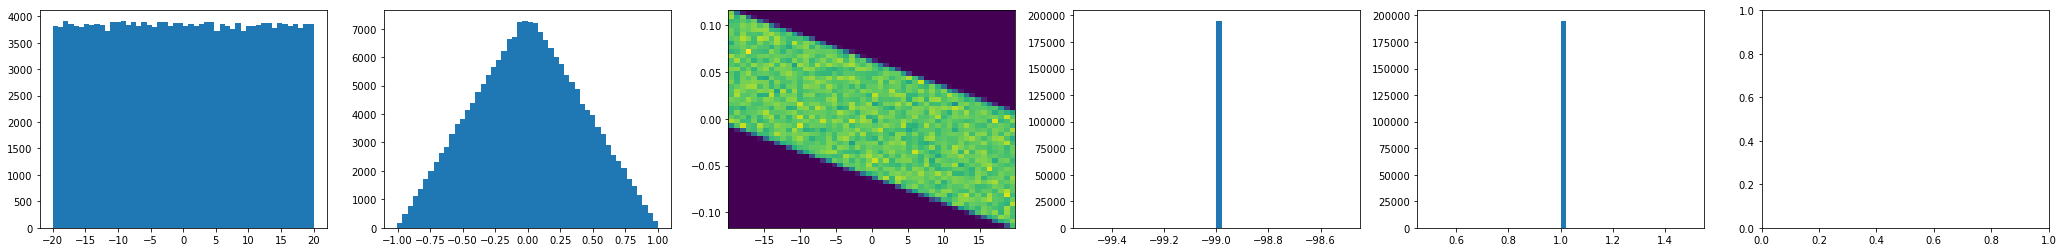

In [13]:
ncols, nrows = (6,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()
axs[0].hist(data['ev_mu_x'][Y_mu==1], bins=50)
axs[1].hist(data['ev_mu_theta'][Y_mu==1]/np.max(data['ev_mu_theta'][Y_mu==1]), bins=50)
axs[2].hist2d(data['ev_mu_x'][Y_mu==1], data['ev_mu_theta'][Y_mu==1], bins=(50,50))

axs[3].hist(data['ev_mu_x'][Y_mu==0], bins=50)
axs[4].hist(data['ev_mu_theta'][Y_mu==0]/np.max(data['ev_mu_theta'][Y_mu==0]), bins=50)

plt.show()

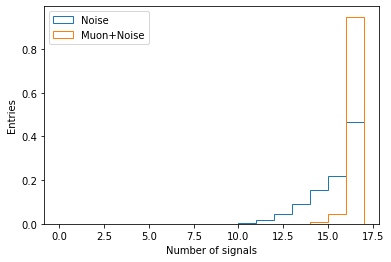

In [14]:
plt.Figure()
plt.hist(data['ev_n_signals'][Y_mu==0], density=1, histtype='step', range=(0,17), bins=17, label='Noise')
plt.hist(data['ev_n_signals'][Y_mu==1], density=1, histtype='step', range=(0,17), bins=17, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of signals')
plt.ylabel('Entries')
plt.show()

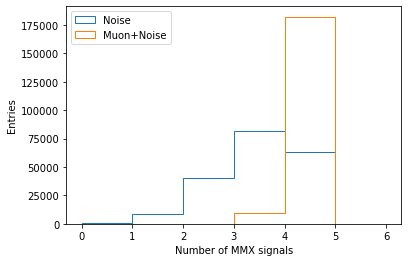

In [15]:
plt.Figure()
h_noise = plt.hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
h_muons = plt.hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMX signals')
plt.ylabel('Entries')
plt.show()

## Define models to compare

In [16]:
import trainingvariables

In [17]:
X_pad = datatools.training_prep(dmat, sig_keys)

~~ Preparing padded matrix ~~


100%|██████████| 387000/387000 [00:53<00:00, 7182.29it/s]

Output data matrix shape: (387000, 20, 19)


In [18]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

linearized = True

In [19]:
import linefit

In [20]:
lfits = linefit.get_fits(dmat, sig_keys)

In [21]:
lfits

array([[-6.07121507e-02,  1.82720395e+01,  1.08248447e+03],
       [ 7.95468610e-02, -1.73006593e+01,  1.46140768e+03],
       [-6.36148473e-02,  1.19254372e+01,  4.72236777e+03],
       ...,
       [ 2.21704634e-02, -8.28252545e+00,  4.25371873e+04],
       [ 8.93720125e-04,  4.99315183e+00,  2.15617784e+04],
       [-2.93290127e-02,  5.39865124e+00,  2.94891821e+04]])

In [22]:
lfits_mu = linefit.get_fits(dmat, sig_keys, is_perfect=True, only_x=False)

In [23]:
lfits_theta = np.arctan(lfits[:,0])
lfits_mu_theta = np.arctan(lfits_mu[:,0])

In [24]:
# lfits_theta[np.arctan(lfits[:,0])<0] = -(lfits_theta[np.arctan(lfits[:,0])<0] + np.pi/2 )
# lfits_theta[np.arctan(lfits[:,0])>0] = -(lfits_theta[np.arctan(lfits[:,0])>0] - np.pi/2 )

# lfits_mu_theta[np.arctan(lfits_mu[:,0])<0] = -(lfits_mu_theta[np.arctan(lfits_mu[:,0])<0] + np.pi/2 )
# lfits_mu_theta[np.arctan(lfits_mu[:,0])>0] = -(lfits_mu_theta[np.arctan(lfits_mu[:,0])>0] - np.pi/2 )

In [25]:
lfits_theta

array([-0.06063772,  0.07937971, -0.06352924, ...,  0.02216683,
        0.00089372, -0.02932061])

In [33]:
mod_list = [

["16673",  "../models/MyTCN_5,3,1:10,3,1_100_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["14758",  "../models/MyTCN_5,4,1:10,4,1_100_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["6943",  "../models/MyTCN_5,3,1:5,3,1_50:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["19658",  "../models/MyTCN_5,4,1:10,4,1_100:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["38143",  "../models/MyTCN_10,3,1:20,3,1_100:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["11023",  "../models/MyTCN_5,3,1:10,3,1_50:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["803",  "../models/MyTCN_10,4,1_none_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["5153",  "../models/MyTCN_5,4,1:5,4,1_50:25_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["5593",  "../models/MyTCN_5,3,1:5,3,1_50:25_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["17693",  "../models/MyTCN_10,4,1_100_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["73603",  "../models/MyTCN_30,3,1:40,3,1_100:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["22593",  "../models/MyTCN_10,4,1_100:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["6503",  "../models/MyTCN_5,4,1:5,4,1_50:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["8593",  "../models/MyTCN_5,3,1:5,3,1_100_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["12553",  "../models/MyTCN_5,4,1:5,4,1_100:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["55573",  "../models/MyTCN_20,3,1:30,3,1_100:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["10108",  "../models/MyTCN_5,4,1:10,4,1_50:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["8758",  "../models/MyTCN_5,4,1:10,4,1_50:25_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
["11543",  "../models/MyTCN_10,4,1_50:50_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"],
    
]
mdict = {}

for imod,mod in enumerate(mod_list):
    
    m_name = str(imod)+'_'+str(mod[0]) + '_'
    m_name += 'flat' if 'Flatten' in mod[1] else 'avg'
    
    mdict[m_name] = {
        "loc": mod[1],
        "data_det": False,
        "data_flat": False,
        "color": f"C{len(mdict)+2}",
        "x_reg_out": 1,
        "a_reg_out": 2
    }
    

In [34]:
for mod in mdict:
    
    if 'yhat' in mdict[mod].keys():
        print("Already added this model")
        continue
    
    if mdict[mod]['data_det']:
        X_prep = X_det
    else:
        X_prep = X_pad
        
    
    vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
    training_vars = trainingvariables.tvars
    for tv in training_vars:
        vars_of_interest[sig_keys.index(tv)] = 1
    mdict[mod]['x'] = X_prep[:,:,vars_of_interest]
    mdict[mod]['x_keys'] = np.array(sig_keys)[vars_of_interest]
    
    if mdict[mod]['data_flat']:
        mdict[mod]['x'] = np.reshape(mdict[mod]['x'], (mdict[mod]['x'].shape[0], mdict[mod]['x'].shape[1]*mdict[mod]['x'].shape[2]))
    
    model = keras.models.load_model(mdict[mod]['loc'],compile=False)
    
    preds = model.predict(mdict[mod]['x'], batch_size=1024)
    
    mdict[mod]['yhat'] = sigmoid(preds[:,0]) if linearized else preds[:,0]
    
    mult_fact = max(data['ev_mu_x'])
    mult_facta = max(data['ev_mu_theta'])
    
    all_weights = np.array([])
    for layer in model.layers:
        for w in layer.weights:
            all_weights = np.concatenate( [w.numpy().flatten(), all_weights] )
    mdict[mod]['nweights'] = all_weights
    
    if 'x_reg_out' in mdict[mod]:
        mdict[mod]['x_reg'] = preds[:,mdict[mod]['x_reg_out']]*mult_fact
        
    if 'a_reg_out' in mdict[mod]:
        mdict[mod]['a_reg'] = preds[:,mdict[mod]['a_reg_out']]*mult_facta

## Make plots

<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )


[-0.06238345  0.08181497 -0.06559399 ...  0.10049801 -0.0586641
 -0.0020011 ]
[-0.05969106  0.08081832 -0.06394065 ...  0.09674057 -0.05675934
  0.00094656]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )


[-6.3959360e-02  7.8490265e-02 -6.4589217e-02 ...  9.6901789e-02
 -5.9428565e-02 -7.3898968e-06]
[-0.06143702  0.07997486 -0.06427432 ...  0.09916309 -0.0596875
 -0.00059597]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )


[-0.06309406  0.0810298  -0.06480588 ...  0.1017943  -0.06009173
 -0.00909312]
[-0.0618033   0.08159108 -0.06487057 ...  0.09998523 -0.05883924
 -0.00048896]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )


[-0.05926885  0.07798001 -0.06365089 ...  0.09492318 -0.05509673
 -0.00701363]
[-0.06145518  0.08040375 -0.06542612 ...  0.0988193  -0.05999276
 -0.0001975 ]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )


[-6.2829413e-02  7.9711042e-02 -6.5006174e-02 ...  9.8492756e-02
 -5.9349887e-02  1.4769111e-05]
[-0.06566965  0.08220258 -0.06600362 ...  0.10093671 -0.05773922
 -0.00197914]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[-0.06449795  0.07920873 -0.06502674 ...  0.09925896 -0.05905024
 -0.01090374]
[-0.06259179  0.08298144 -0.06402981 ...  0.09932379 -0.0586363
 -0.00350749]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[-6.2299673e-02  8.3186947e-02 -6.5583520e-02 ...  9.8658472e-02
 -5.7757705e-02  1.0333021e-05]
[-0.06163048  0.08118176 -0.06669649 ...  0.09944638 -0.06032237
  0.00100246]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )


[-0.0631357   0.080068   -0.06290145 ...  0.0972313  -0.05704123
 -0.0002745 ]
[-0.06238806  0.07991723 -0.06588952 ...  0.10009641 -0.05734877
 -0.00814155]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )
<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )


[-6.3657761e-02  8.1600904e-02 -6.4747579e-02 ...  9.8351583e-02
 -6.0967475e-02  1.8453880e-05]
[-6.2083289e-02  8.2134329e-02 -6.4079992e-02 ...  9.9314556e-02
 -5.9382331e-02 -1.7398823e-05]


<ipython-input-35-3bf654672e61>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
<ipython-input-35-3bf654672e61>:44: RuntimeWarning: divide by zero encountered in log2
  axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )


[-0.05952569  0.08015155 -0.06445442 ...  0.09583318 -0.05924475
 -0.00444421]


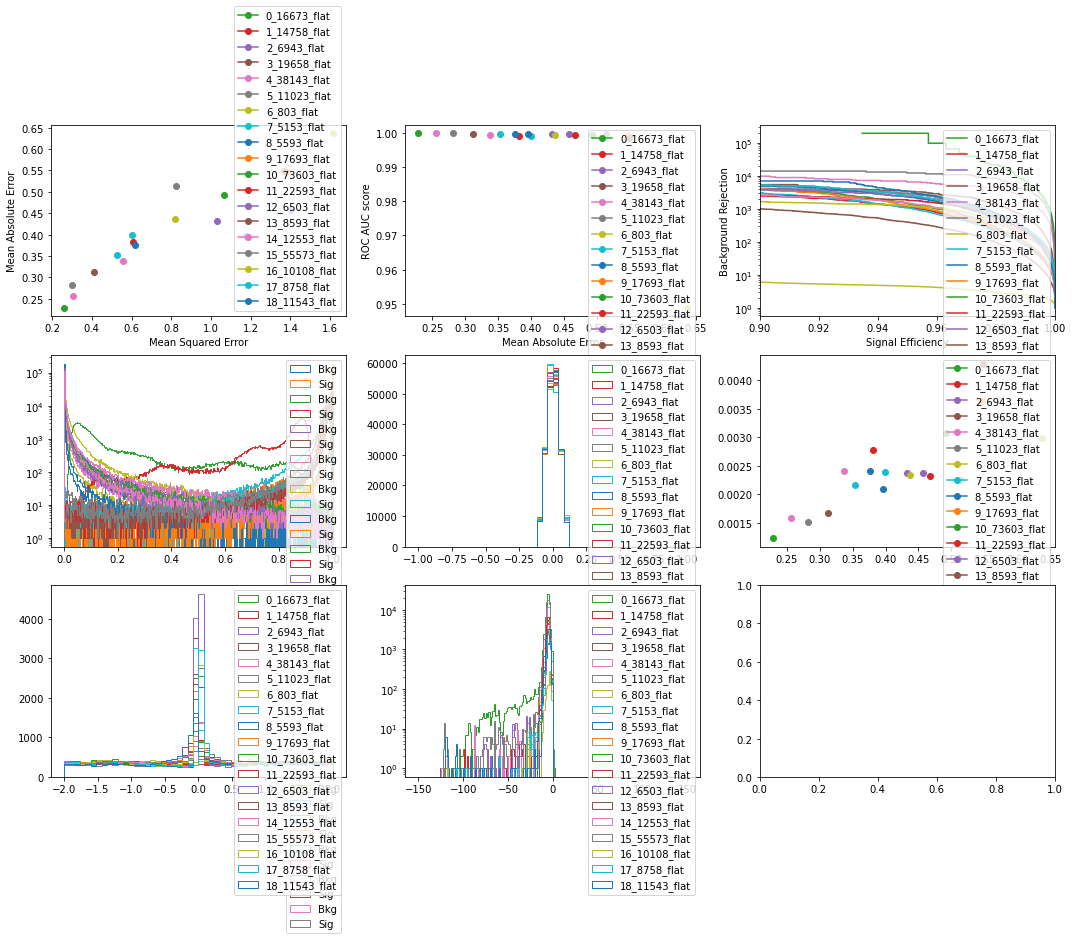

In [35]:
ncols, nrows = (3,3)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

this_cut=(Y_mu==1)

chi2_mse = metrics.mean_squared_error( data['ev_mu_x'][this_cut], lfits[this_cut][:,1] )
chi2_mae = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], lfits[this_cut][:,1] )

# axs.plot(chi2_mse, chi2_mae, marker='+', label='Chi 2')

# chi2mu_mse = metrics.mean_squared_error( data['ev_mu_x'][this_cut], lfits_mu[this_cut][:,1] )
# chi2mu_mae = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], lfits_mu[this_cut][:,1] )

# axs.plot(chi2mu_mse, chi2mu_mae, label='Chi 2 (mu)')

for mod in mdict:
    
    mod_mse = metrics.mean_squared_error( data['ev_mu_x'][this_cut], mdict[mod]['x_reg'][this_cut] )
    mod_mae = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], mdict[mod]['x_reg'][this_cut] )
    mod_auc = metrics.roc_auc_score( Y_mu, mdict[mod]['yhat'] )
    fpr, tpr, thresholds = metrics.roc_curve( Y_mu, mdict[mod]['yhat'] )
    
    axs[0].plot((mod_mse), mod_mae, marker='o', color=mdict[mod]['color'], label=f'{mod}')
    
    axs[1].plot(mod_mae, mod_auc, marker='o', color=mdict[mod]['color'], label=f'{mod}')
    
    axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
    
    axs[3].hist( mdict[mod]['yhat'][Y_mu==0], histtype='step', bins=500, range=(0,1), label='Bkg' )
    axs[3].hist( mdict[mod]['yhat'][Y_mu==1], histtype='step', bins=500, range=(0,1), label='Sig' )
    
    if 'a_reg' in mdict[mod]:
        axs[4].hist( mdict[mod]['a_reg'][Y_mu==1], bins=50, range=(-1,1), histtype='step', color=mdict[mod]['color'], label=f'{mod}' )
        print(mdict[mod]['a_reg'][Y_mu==1])
        
        moda_mae = metrics.mean_absolute_error( data['ev_mu_theta'][this_cut], mdict[mod]['a_reg'][this_cut] )
        
        axs[5].plot(mod_mae, moda_mae, marker='o', color=mdict[mod]['color'], label=f'{mod}')
        
    if 'x_reg' in mdict[mod]:
        axs[6].hist( mdict[mod]['x_reg'][Y_mu==1], bins=50, range=(-2,2), histtype='step', color=mdict[mod]['color'], label=f'{mod}' )
        
    axs[7].hist(np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-150,150), color=mdict[mod]['color'], label=f'{mod}' )

axs[0].set_xlabel("Mean Squared Error")
axs[0].set_ylabel("Mean Absolute Error")

axs[1].set_xlabel("Mean Absolute Error")
axs[1].set_ylabel("ROC AUC score")

axs[2].set_xlabel("Signal Efficiency")
axs[2].set_ylabel("Background Rejection")

axs[0].legend(loc='lower right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
axs[3].legend(loc='upper right')
axs[4].legend(loc='upper right')
axs[5].legend(loc='upper right')
axs[6].legend(loc='upper right')
axs[7].legend(loc='upper right')
axs[7].set_yscale('log')
axs[2].set_xlim(0.9,1)

axs[3].set_yscale('log')

# plt.savefig("plots/scores.pdf")
plt.show()

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


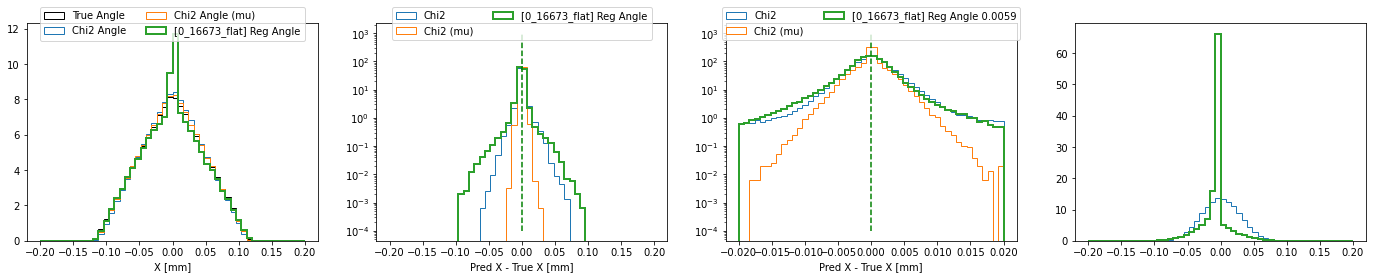

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


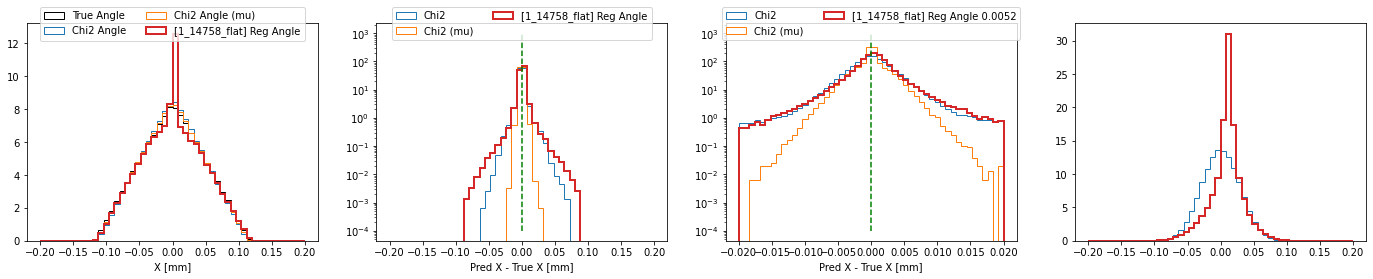

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


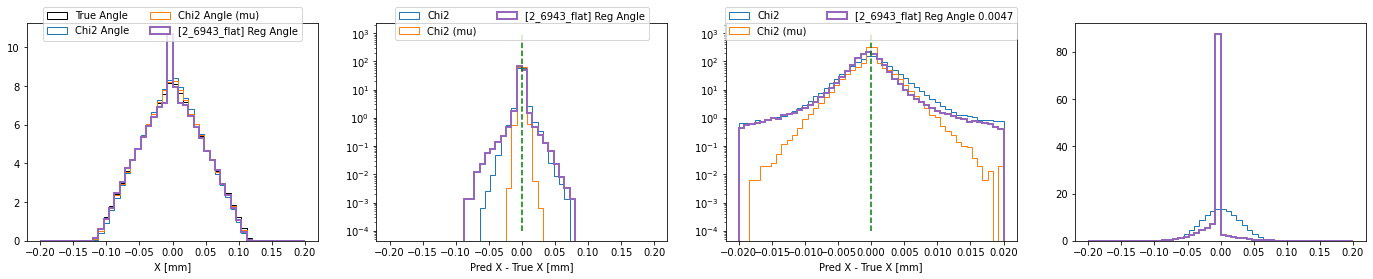

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


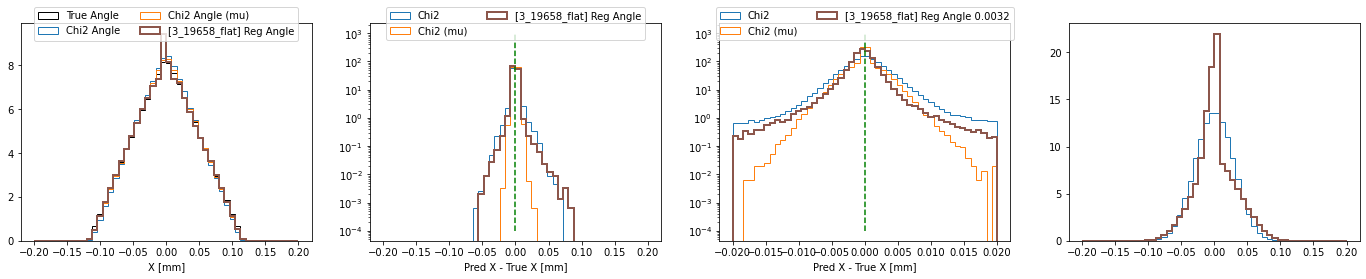

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


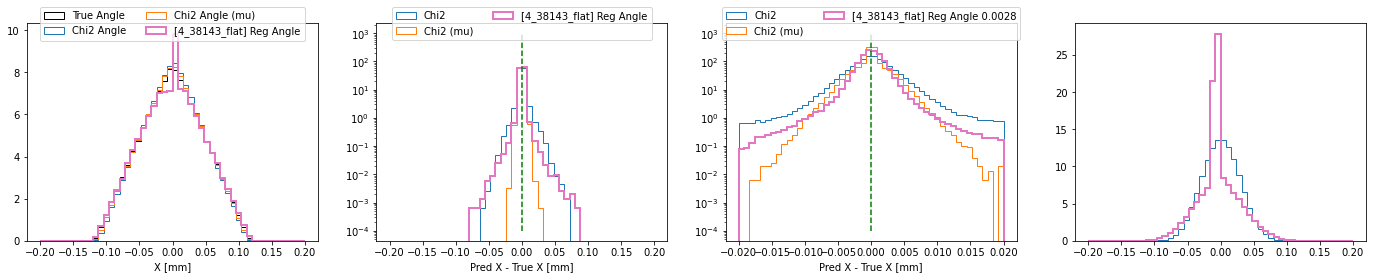

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


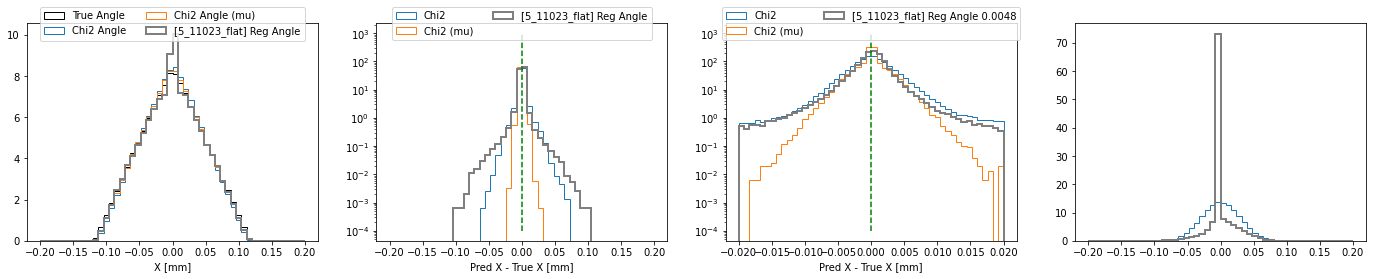

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


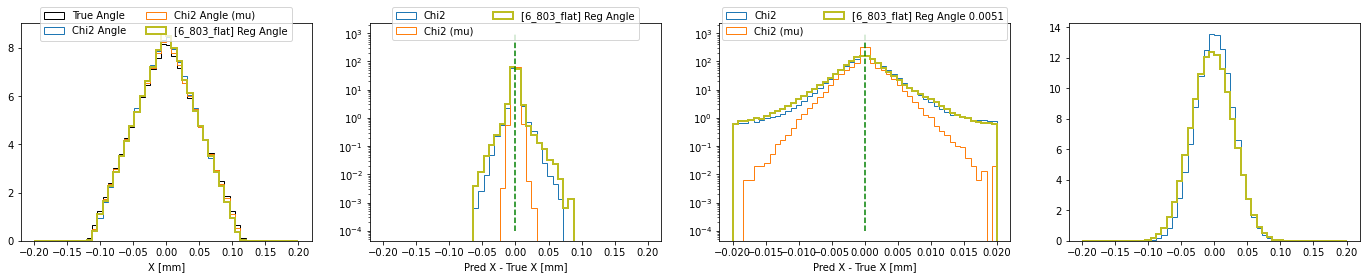

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


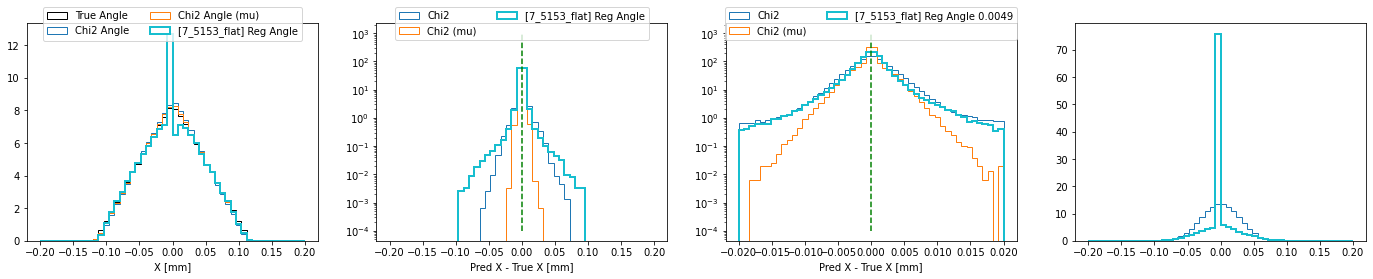

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


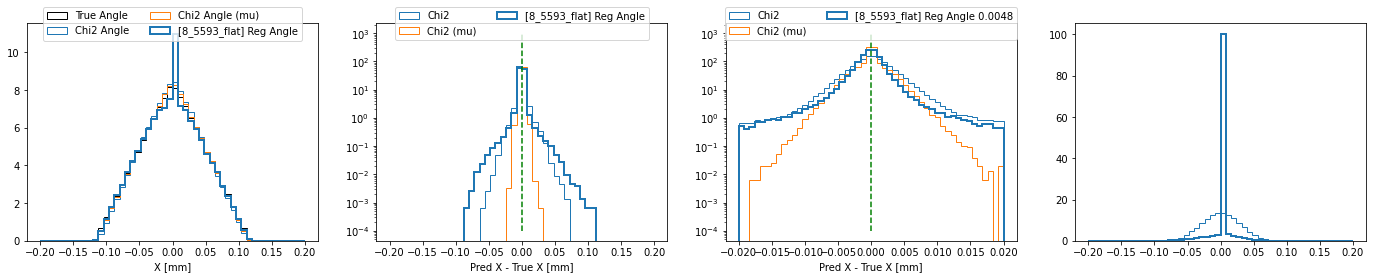

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


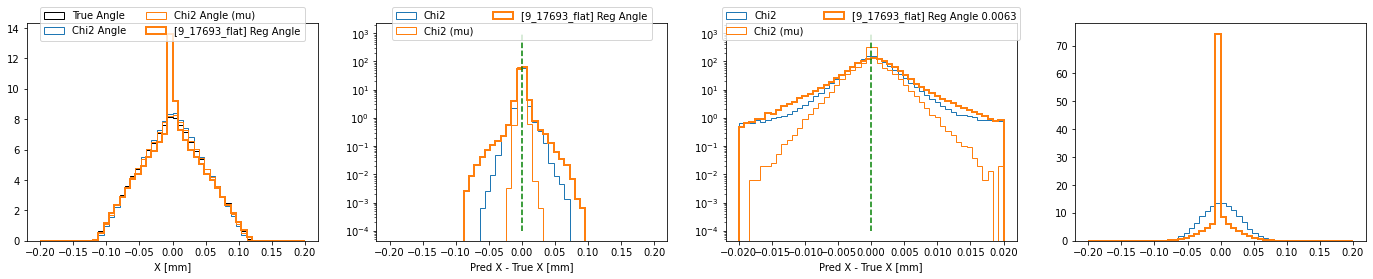

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


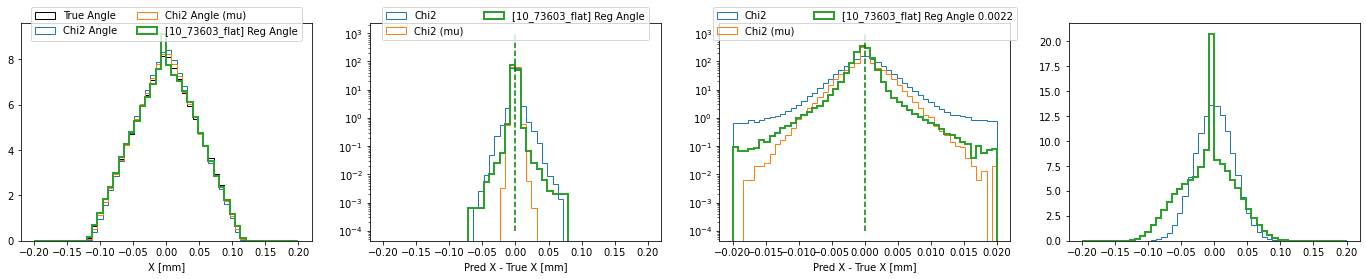

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


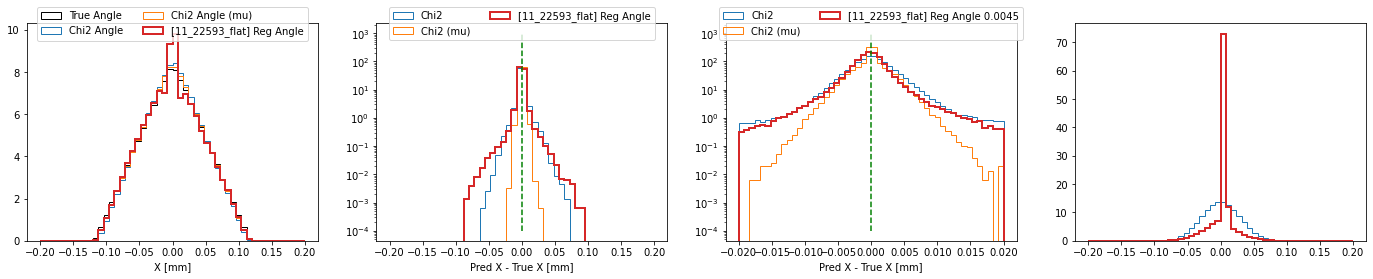

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


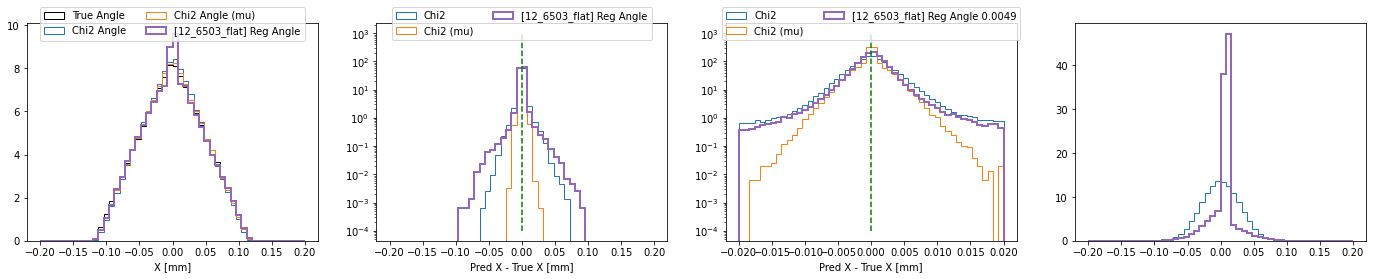

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


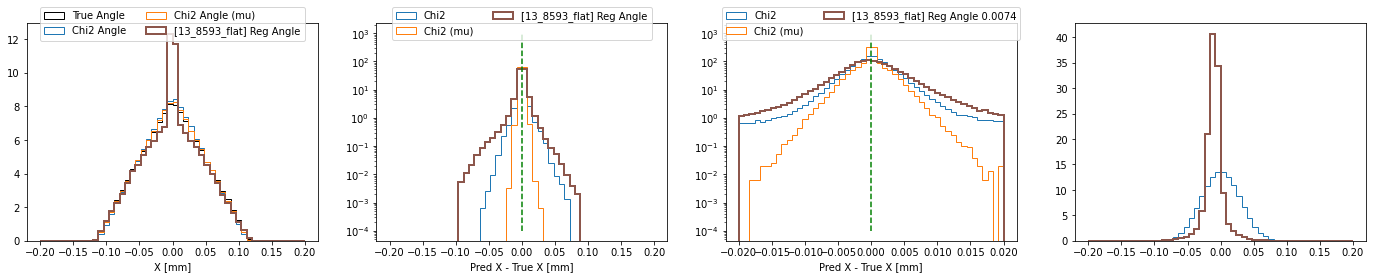

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


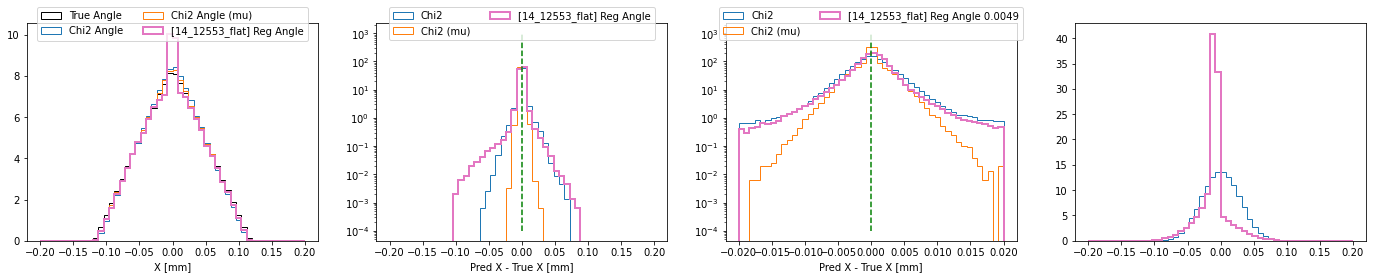

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


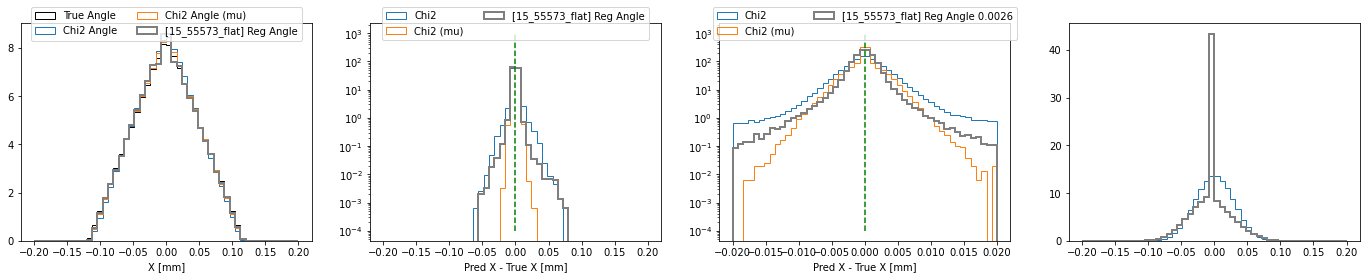

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


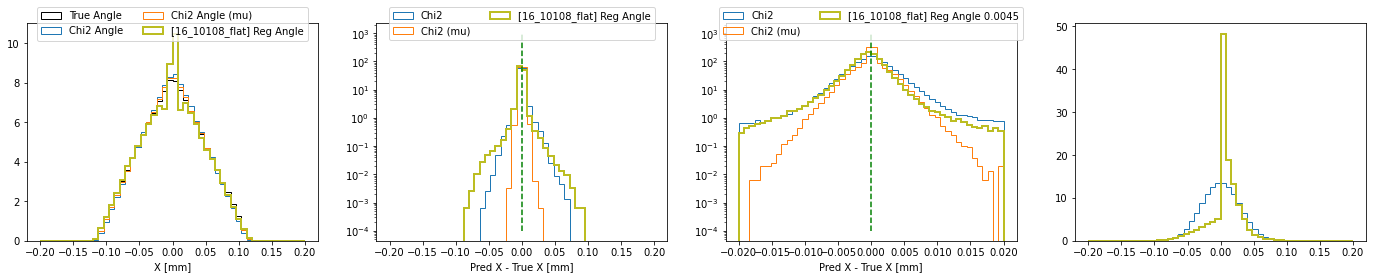

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


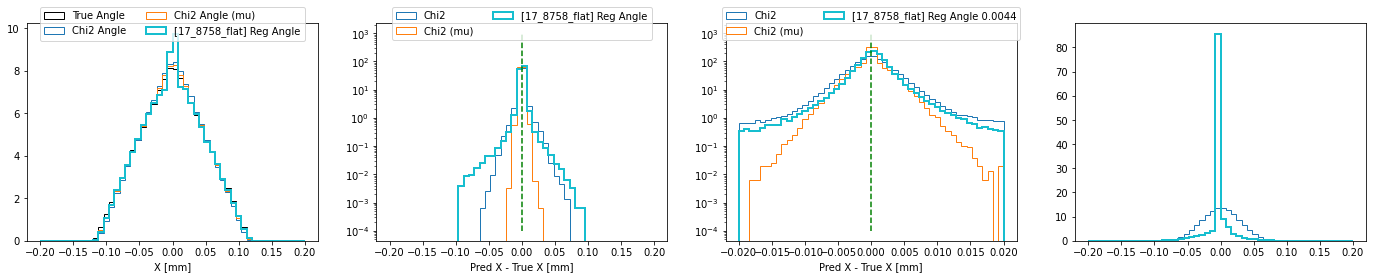

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


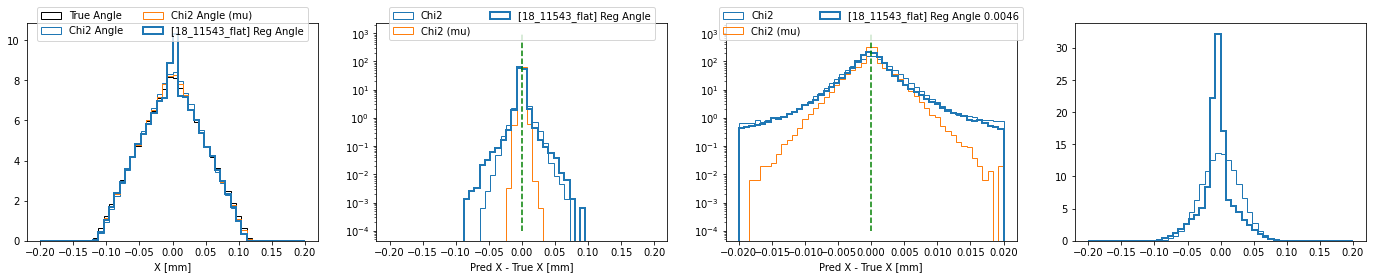

In [36]:
for mod in mdict:

    if 'a_reg' not in mdict[mod]: continue
    
    ncols, nrows = (4,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)


    axs[0].hist(data['ev_mu_theta'][this_cut], histtype='step', range=(-0.2,0.2), density=1, color='black',
                bins=50, label=f'True Angle')

    axs[0].hist(lfits_theta[this_cut], histtype='step', range=(-0.2,0.2), density=1, color='C0',
                bins=50, label=f'Chi2 Angle')

    axs[0].hist(lfits_mu_theta[this_cut], histtype='step', range=(-0.2,0.2), density=1, color='C1',
                bins=50, label=f'Chi2 Angle (mu)')

    axs[1].hist(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1], histtype='step', range=(-0.2,0.2), density=1, color='C0',
                bins=50, label=f'Chi2')

    axs[1].hist(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1], histtype='step', range=(-0.2,0.2), density=1, color='C1',
                bins=50, label=f'Chi2 (mu)')

    axs[2].hist(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1], histtype='step', range=(-0.02,0.02), density=1, color='C0',
                bins=50, label=f'Chi2')

    axs[2].hist(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1], histtype='step', range=(-0.02,0.02), density=1, color='C1',
                bins=50, label=f'Chi2 (mu)')

    axs[3].hist(lfits_theta[Y_mu==0], histtype='step', range=(-0.2,0.2), density=1, color='C0',
                bins=50, label=f'Chi2 Angle')

    axs[3].hist(lfits_mu_theta[Y_mu==0], histtype='step', range=(-0.2,0.2), density=1, color='C1',
                bins=50, label=f'Chi2 Angle (mu)')
        
    if True:
        areg=mdict[mod]['a_reg']
        axs[0].hist(areg[this_cut], histtype='step', range=(-0.2,0.2), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle', linewidth=2)

        axs[1].hist(areg[this_cut] - data['ev_mu_theta'][Y_mu==1], 
                    histtype='step', range=(-0.2,0.2), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle', linewidth=2)

        this_std = (areg[this_cut] - data['ev_mu_theta'][Y_mu==1]).std()
        axs[2].hist(areg[this_cut] - data['ev_mu_theta'][Y_mu==1], 
                    histtype='step', range=(-0.02,0.02), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle {this_std:.4f}', linewidth=2)
        
        axs[3].hist(areg[Y_mu==0], 
                    histtype='step', range=(-0.2,0.2), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle', linewidth=2)
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    
    axs[1].plot([0,0], [1e-4, 1e3], 'g--')
    axs[2].plot([0,0], [1e-4, 1e3], 'g--')
    plt.show()

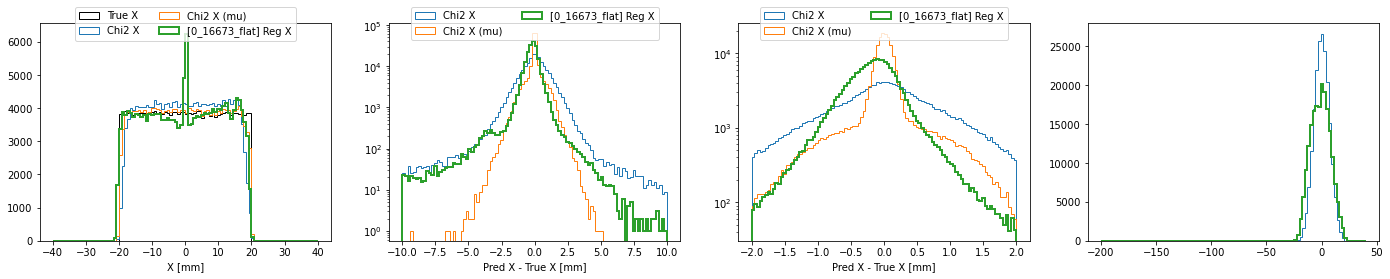

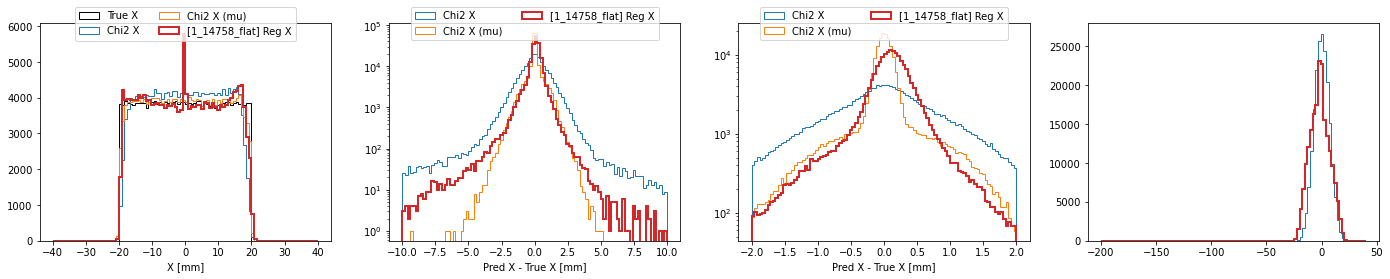

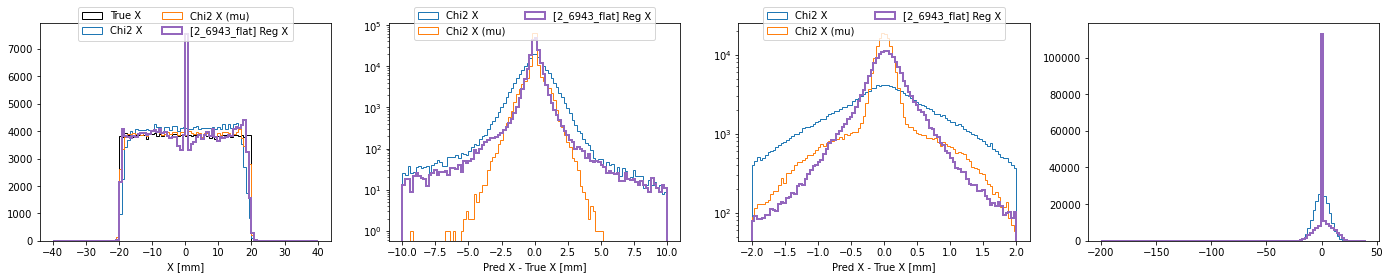

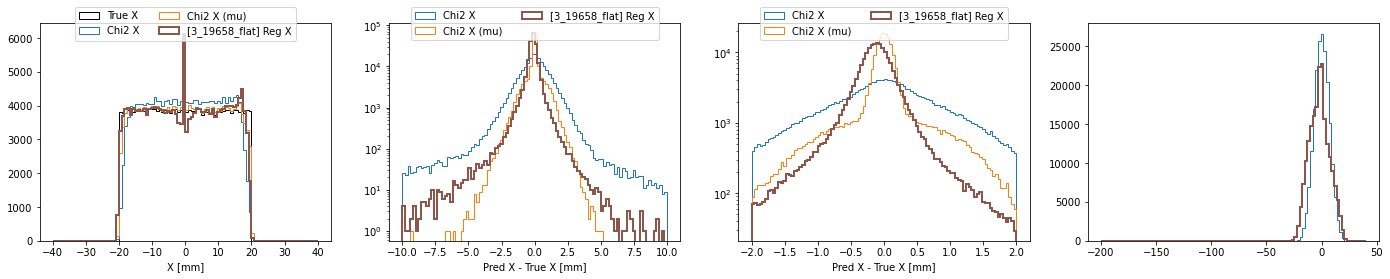

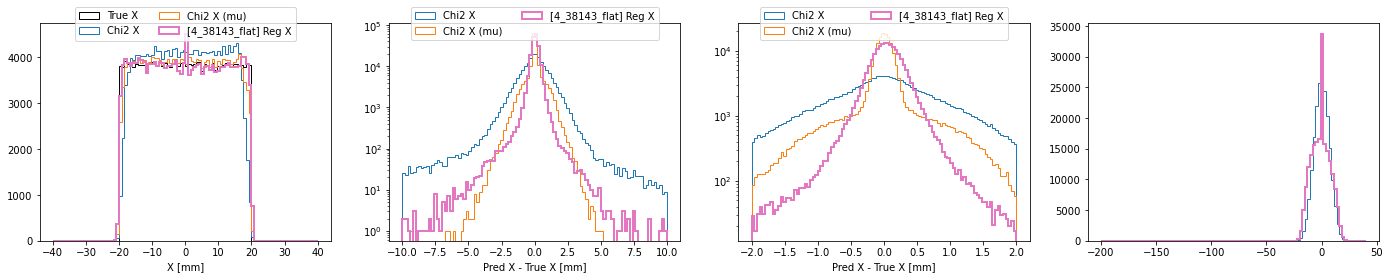

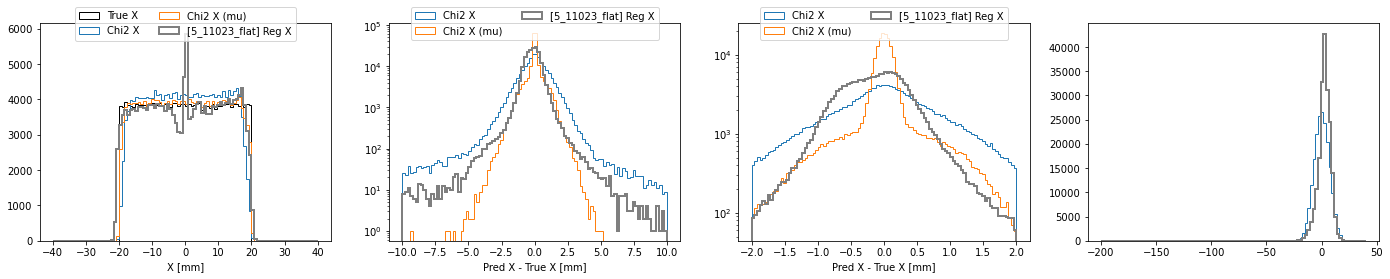

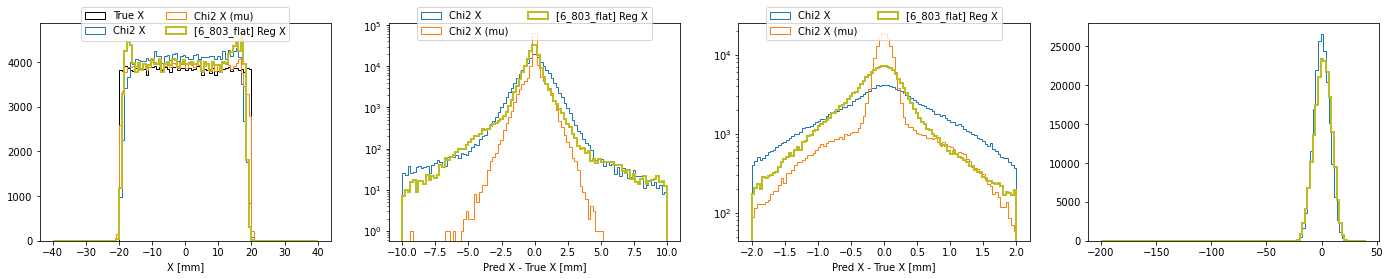

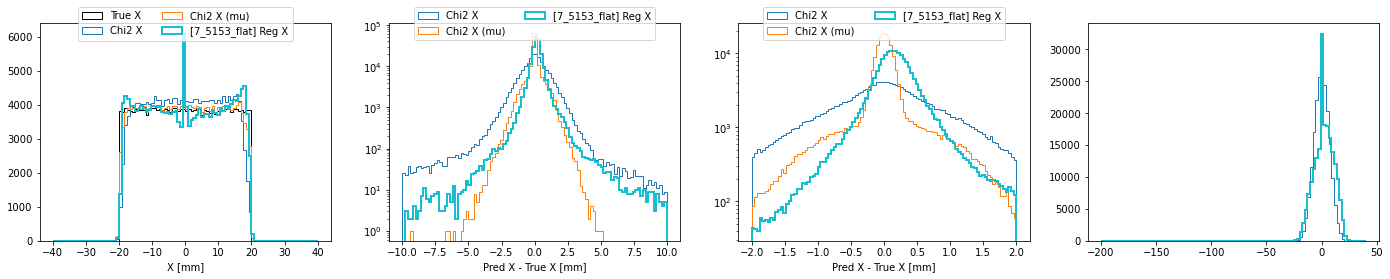

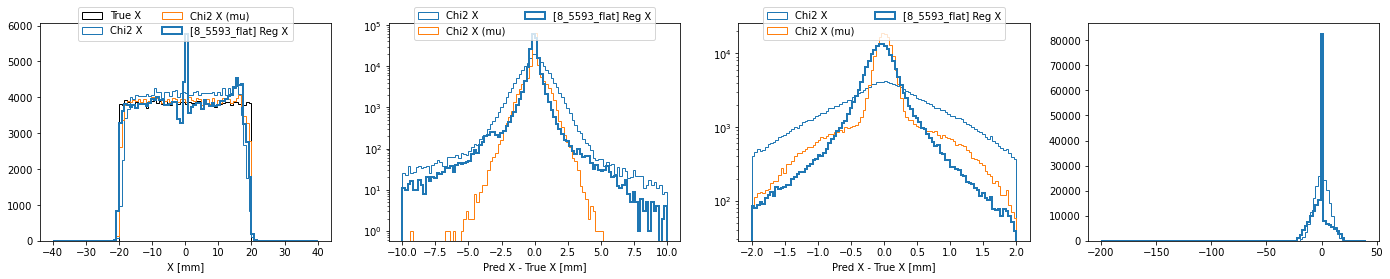

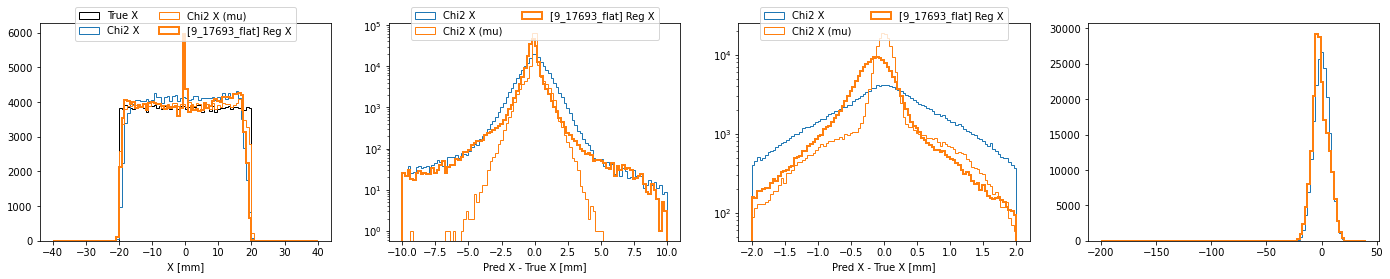

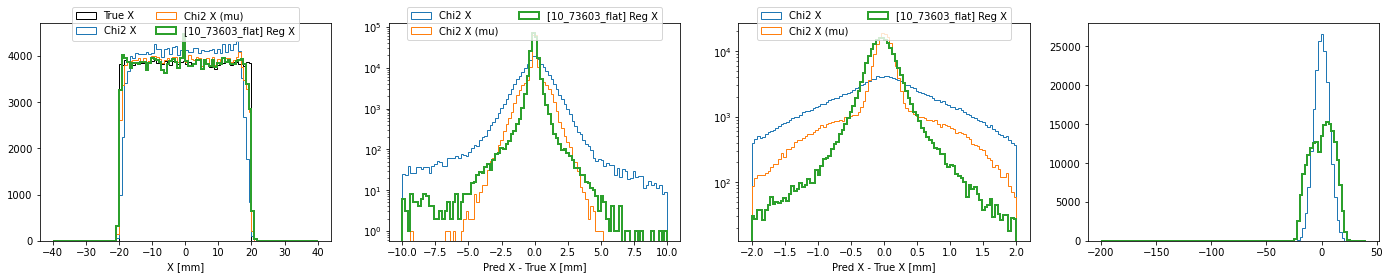

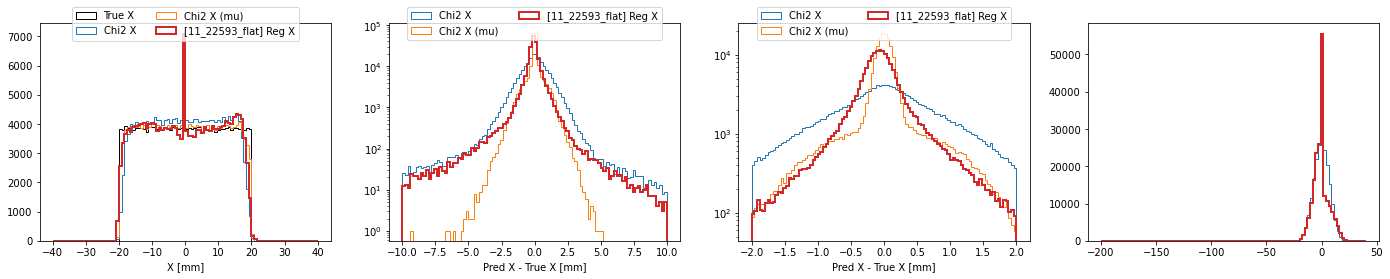

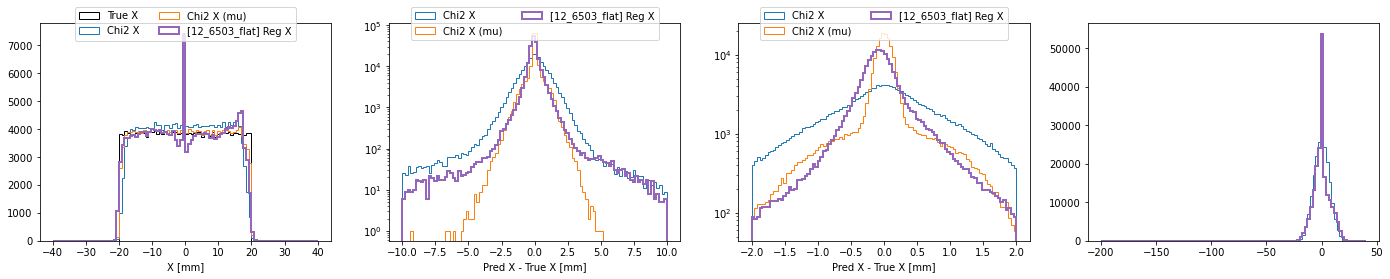

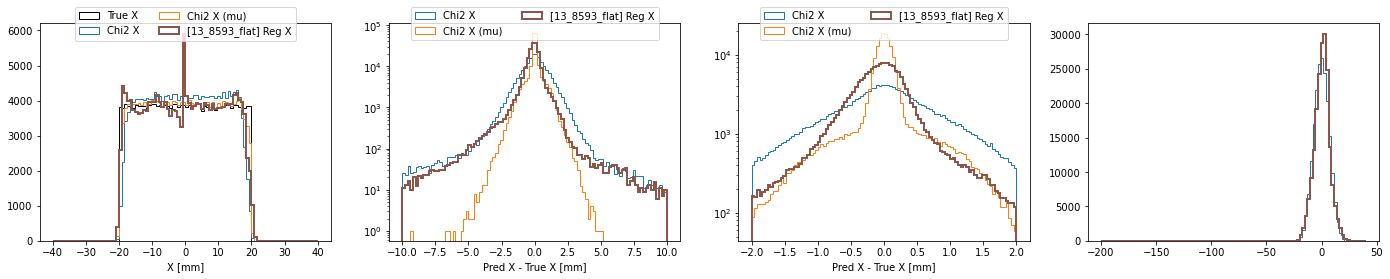

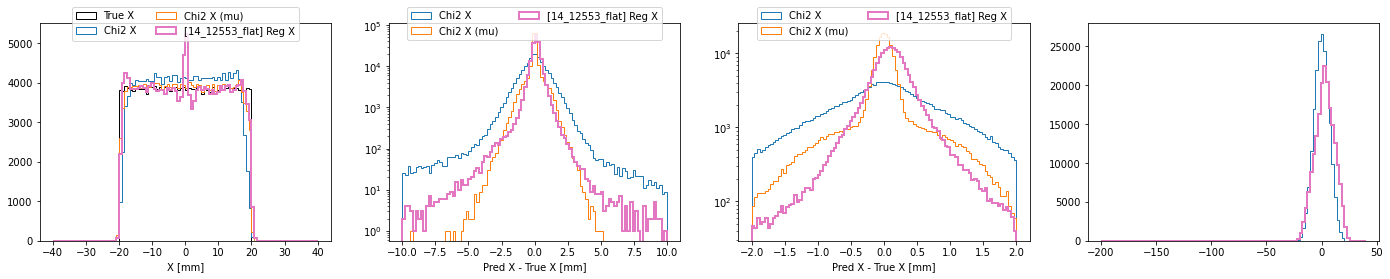

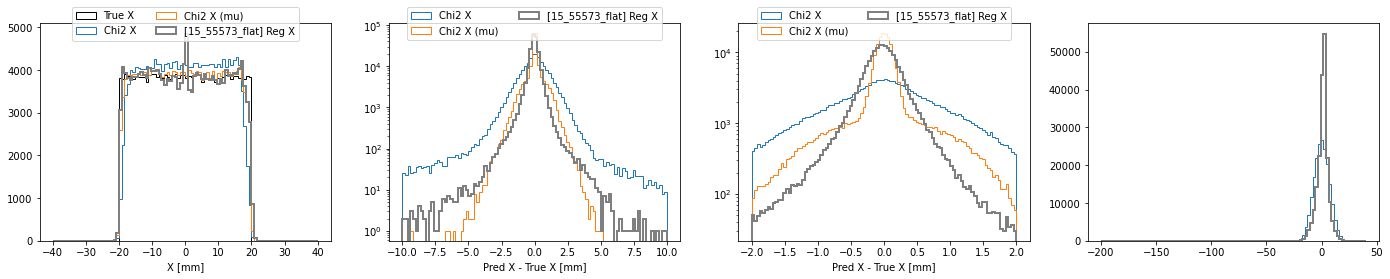

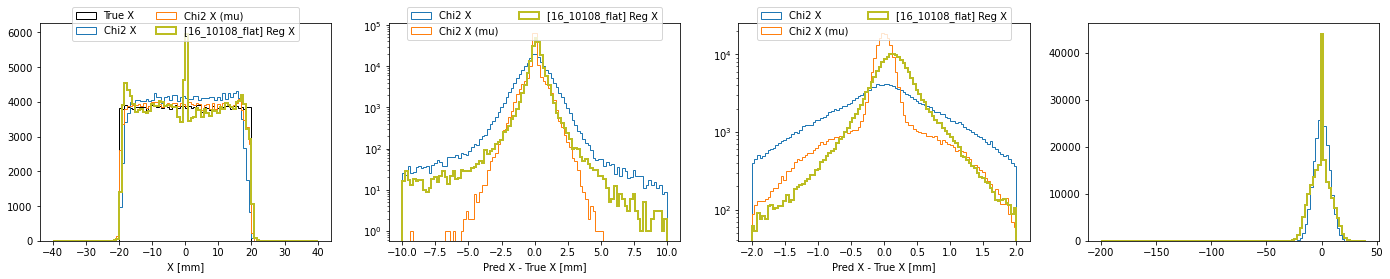

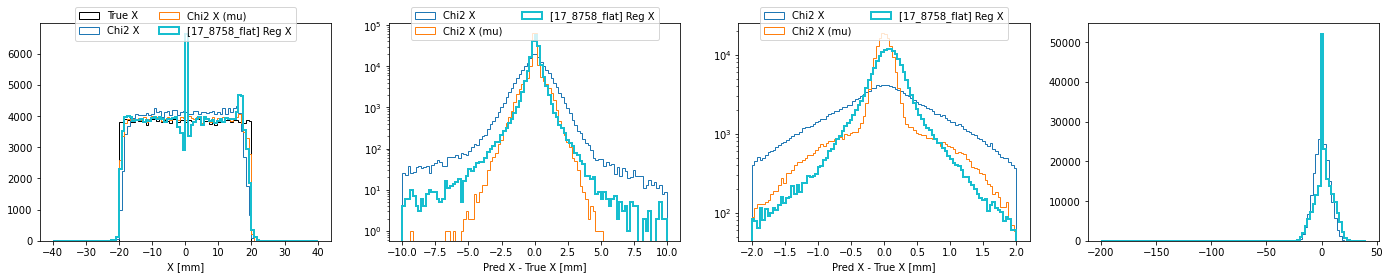

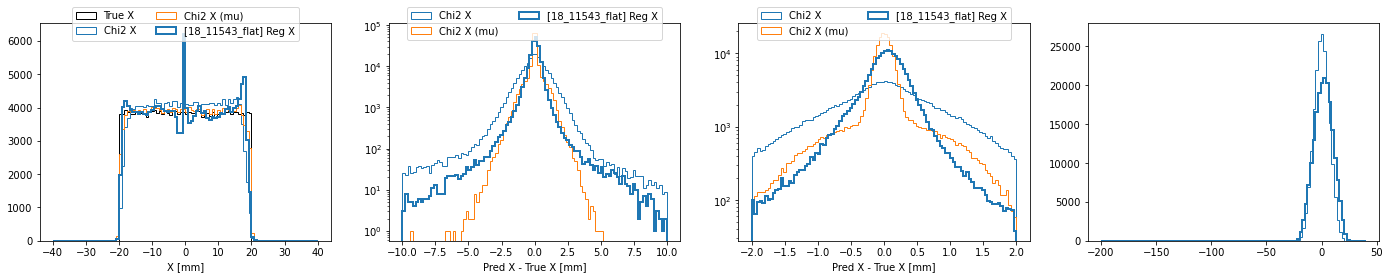

In [37]:
for mod in mdict:


    ncols, nrows = (4,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)


    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='black',
                bins=100, label=f'True X')

    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-40,40), color='C0',
                bins=100, label=f'Chi2 X')

    axs[0].hist(lfits_mu[this_cut][:,1], histtype='step', range=(-40,40), color='C1',
                bins=100, label=f'Chi2 X (mu)')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C0',
                bins=100, label=f'Chi2 X')

    axs[1].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C1',
                bins=100, label=f'Chi2 X (mu)')

    axs[2].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C0',
                bins=100, label=f'Chi2 X')

    axs[2].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C1',
                bins=100, label=f'Chi2 X (mu)')

    axs[3].hist(lfits[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C0',
                bins=100, label=f'Chi2 X')

    axs[3].hist(lfits_mu[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C1',
                bins=100, label=f'Chi2 X (mu)')
    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-40,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][Y_mu==1], 
                    histtype='step', range=(-10,10), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[2].hist(xreg[this_cut] - data['ev_mu_x'][Y_mu==1], 
                    histtype='step', range=(-2,2), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[3].hist(xreg[Y_mu==0], 
                    histtype='step', range=(-200,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    plt.show()

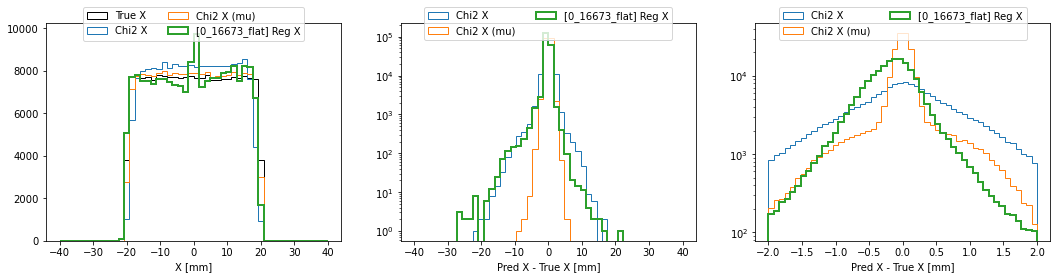

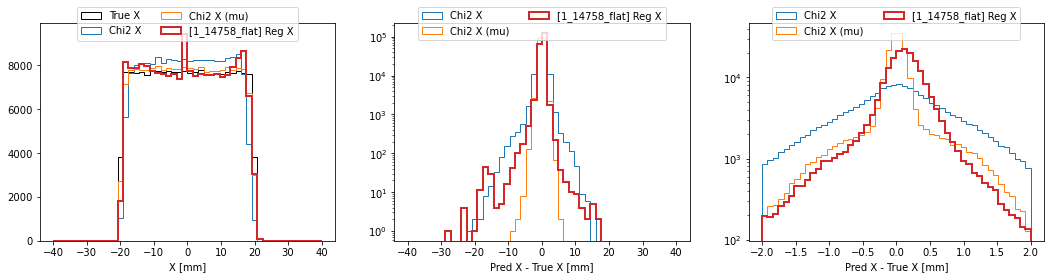

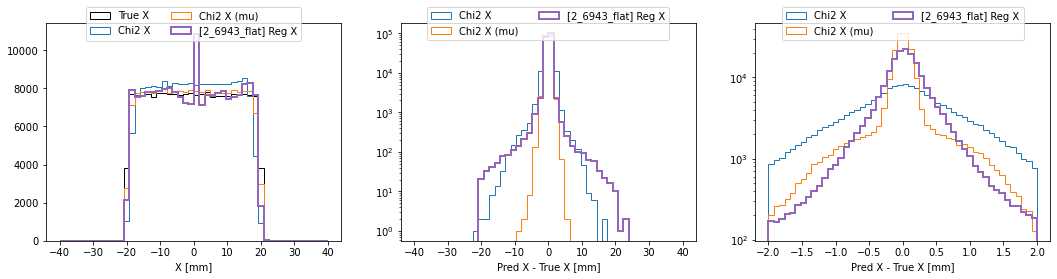

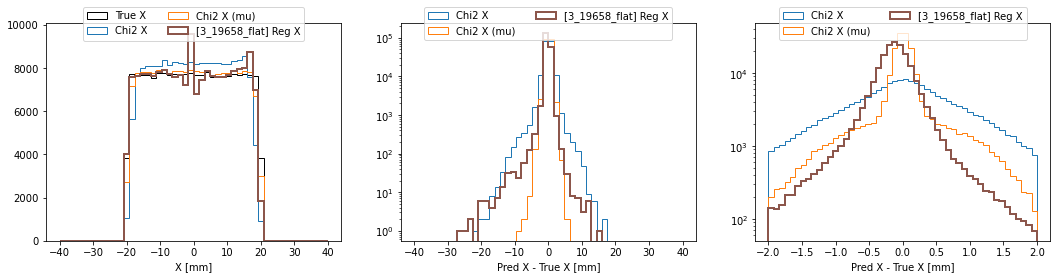

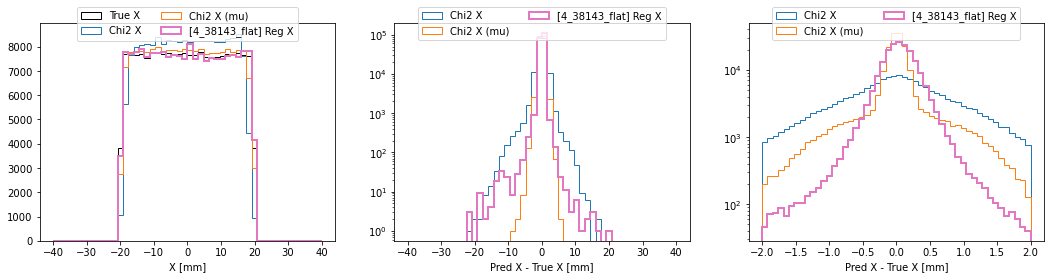

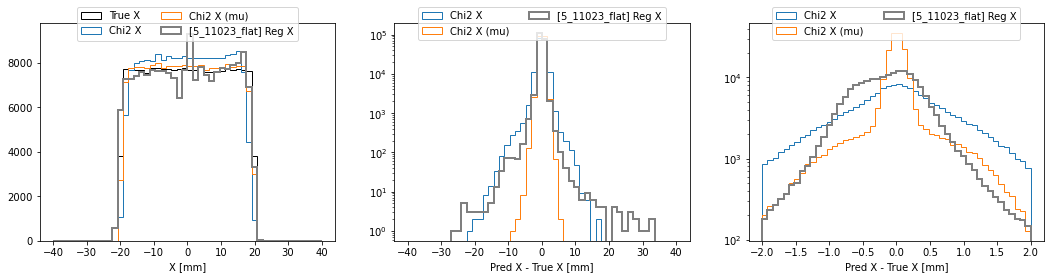

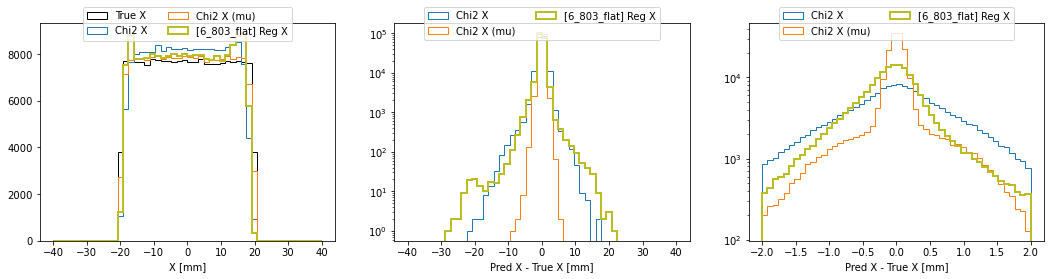

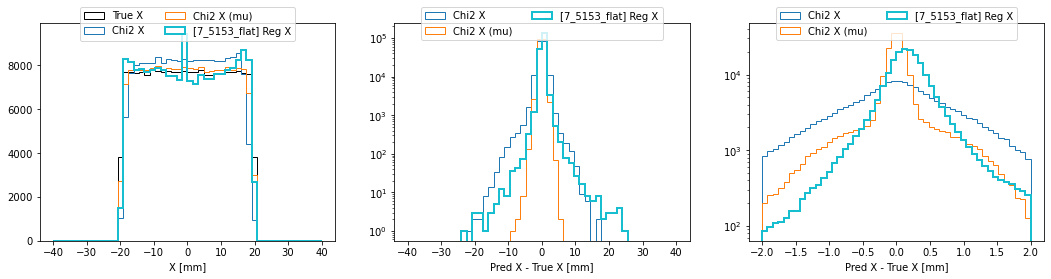

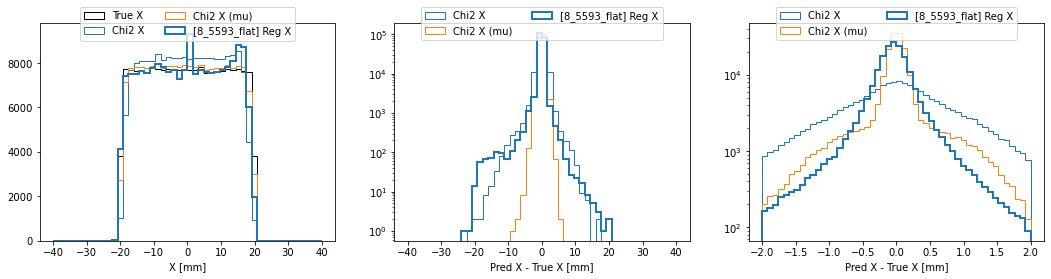

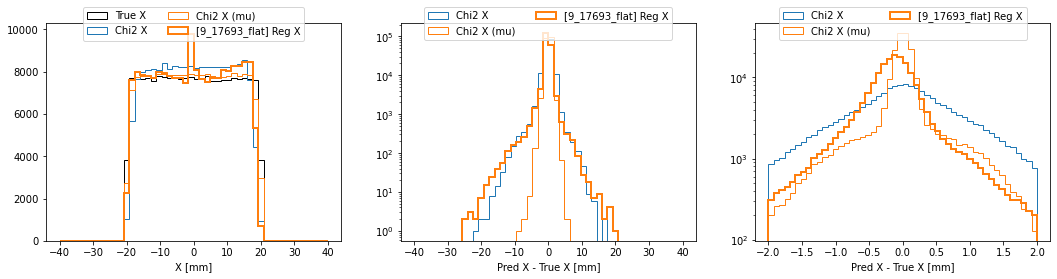

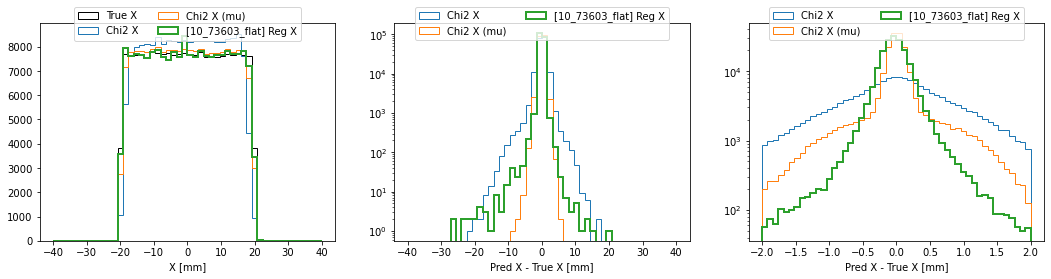

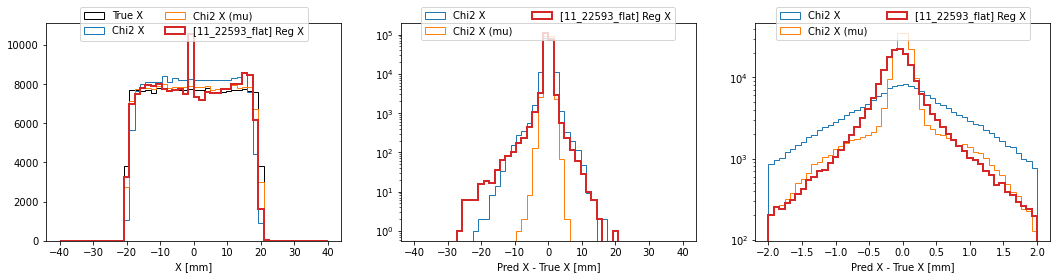

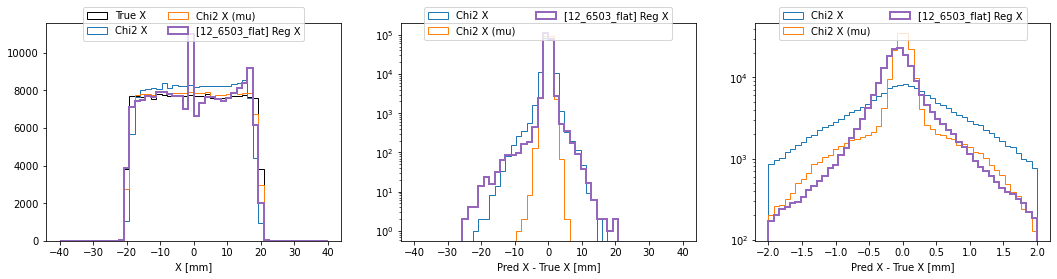

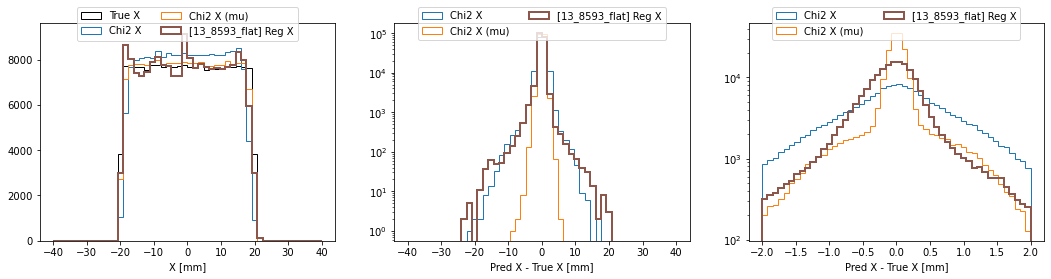

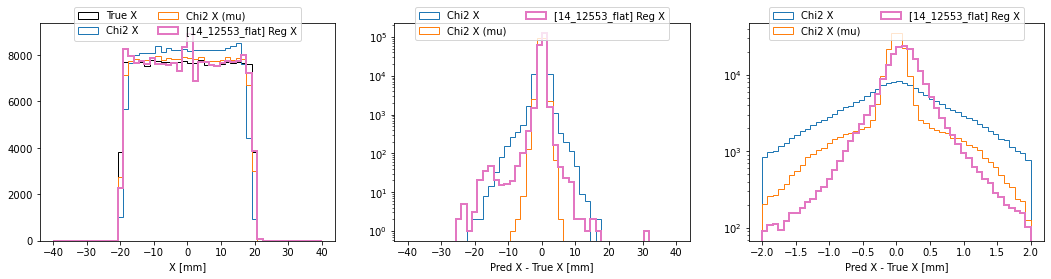

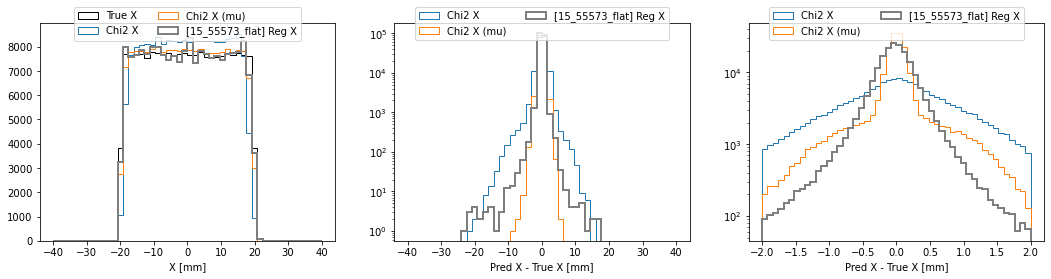

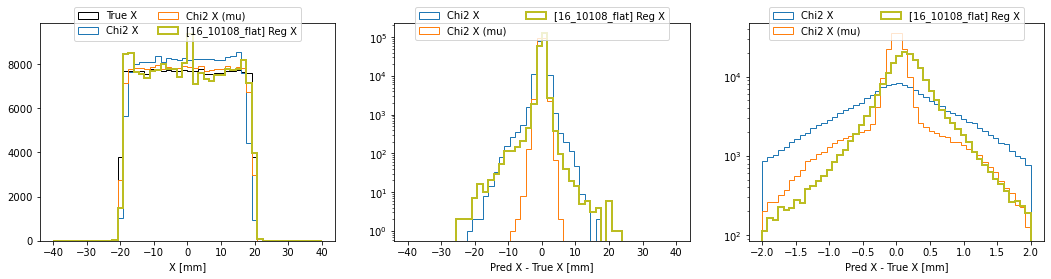

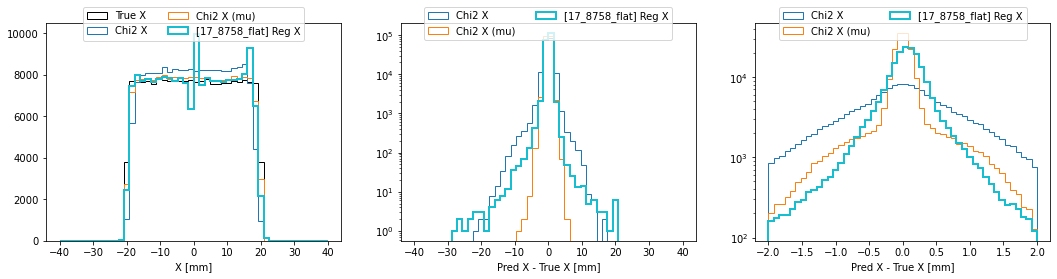

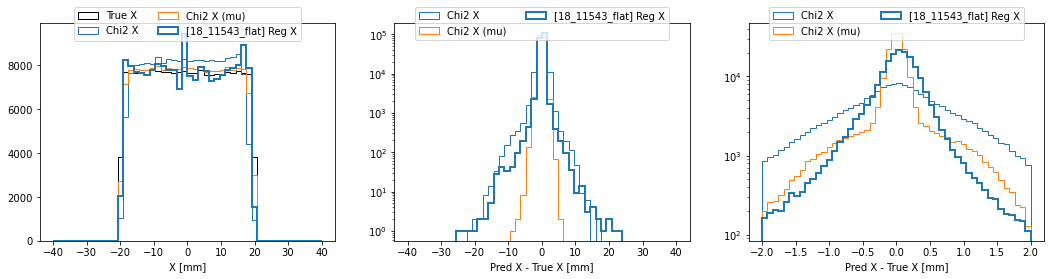

In [38]:
for mod in mdict:


    ncols, nrows = (3,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)*(data['ev_n_mu_signals']>7)


    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='black',
                bins=50, label=f'True X')

    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-40,40), color='C0',
                bins=50, label=f'Chi2 X')

    axs[0].hist(lfits_mu[this_cut][:,1], histtype='step', range=(-40,40), color='C1',
                bins=50, label=f'Chi2 X (mu)')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='C0',
                bins=50, label=f'Chi2 X')

    axs[1].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='C1',
                bins=50, label=f'Chi2 X (mu)')

    axs[2].hist(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-2,2), color='C0',
                bins=50, label=f'Chi2 X')

    axs[2].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-2,2), color='C1',
                bins=50, label=f'Chi2 X (mu)')

    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-40,40), bins=50, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][this_cut], 
                    histtype='step', range=(-40,40), bins=50, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[2].hist(xreg[this_cut] - data['ev_mu_x'][this_cut], 
                    histtype='step', range=(-2,2), bins=50, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    plt.show()

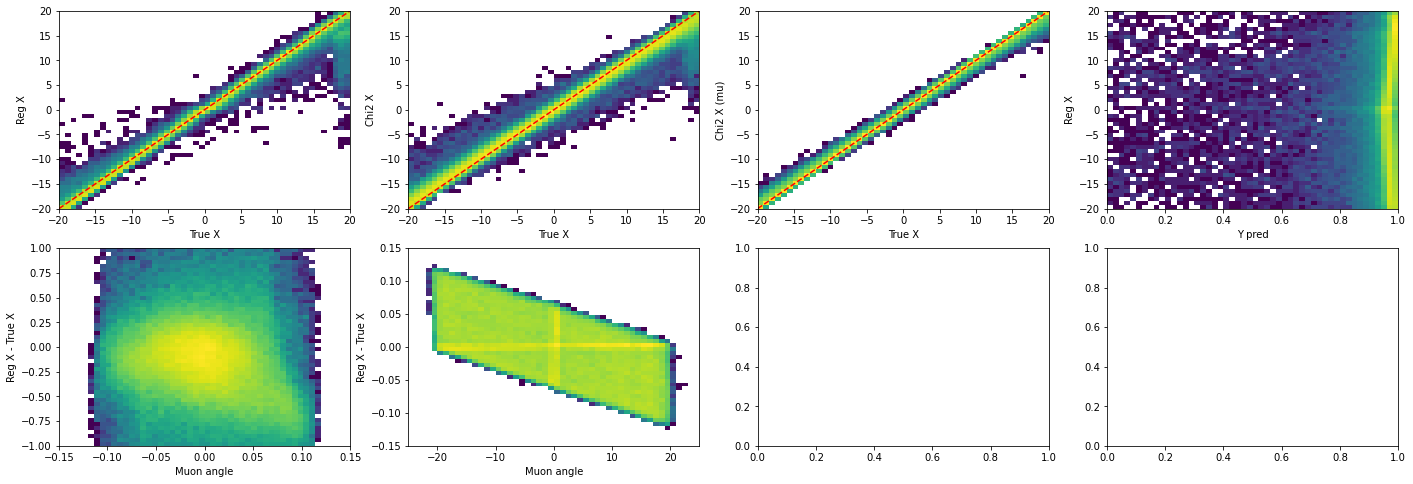

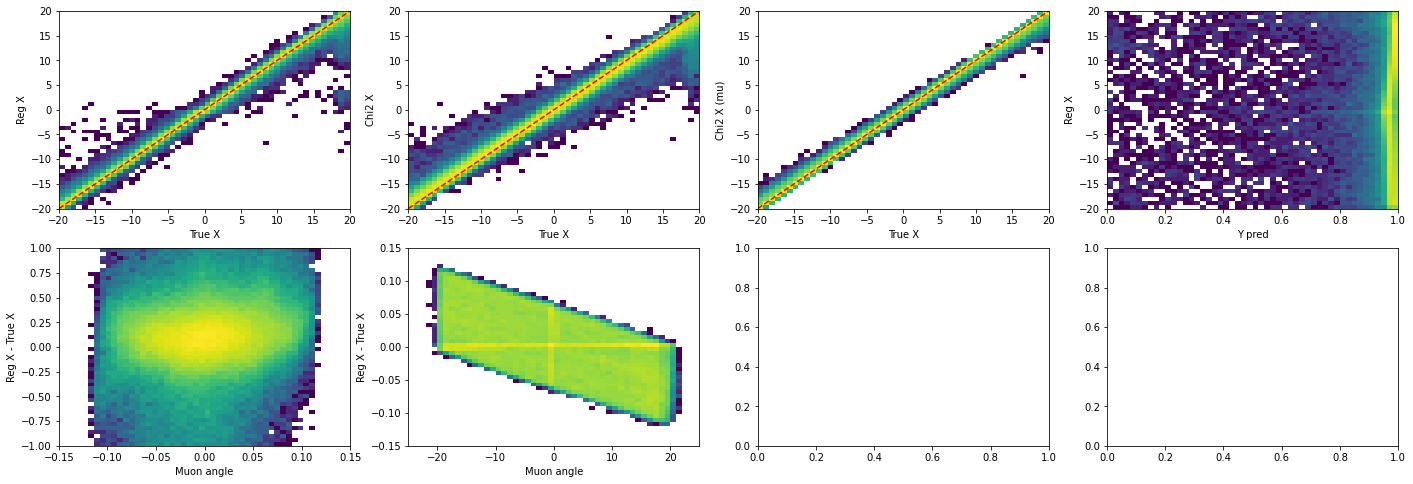

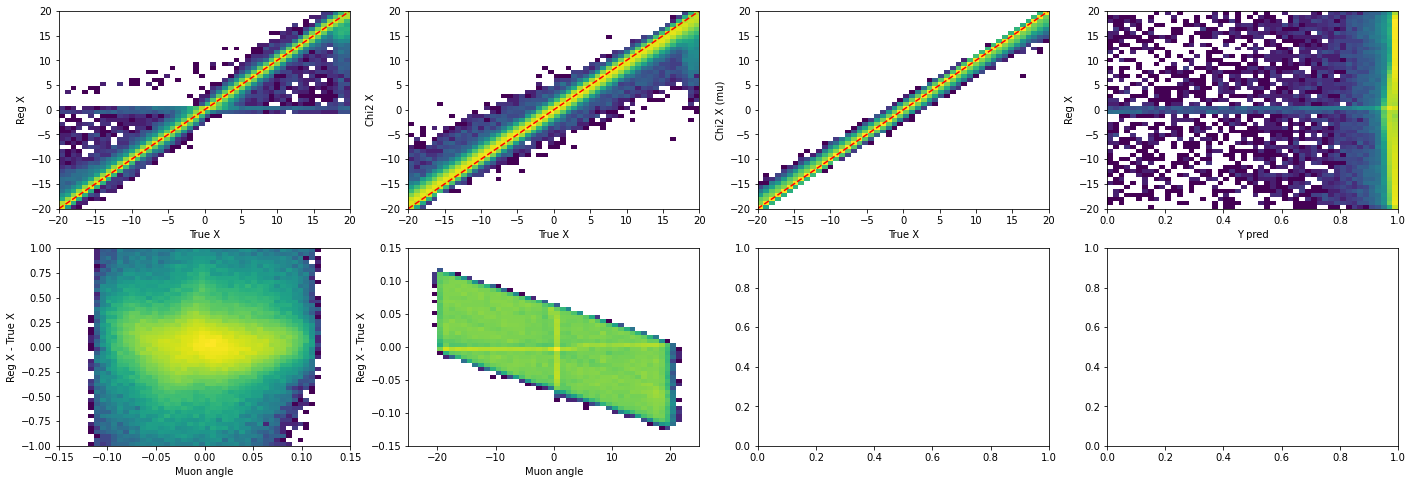

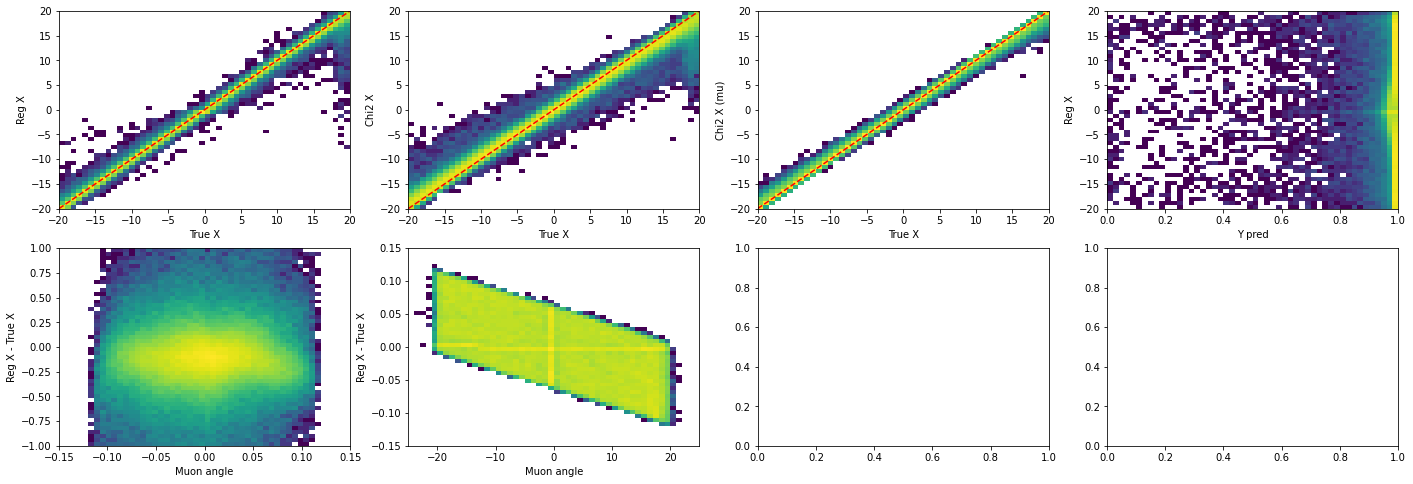

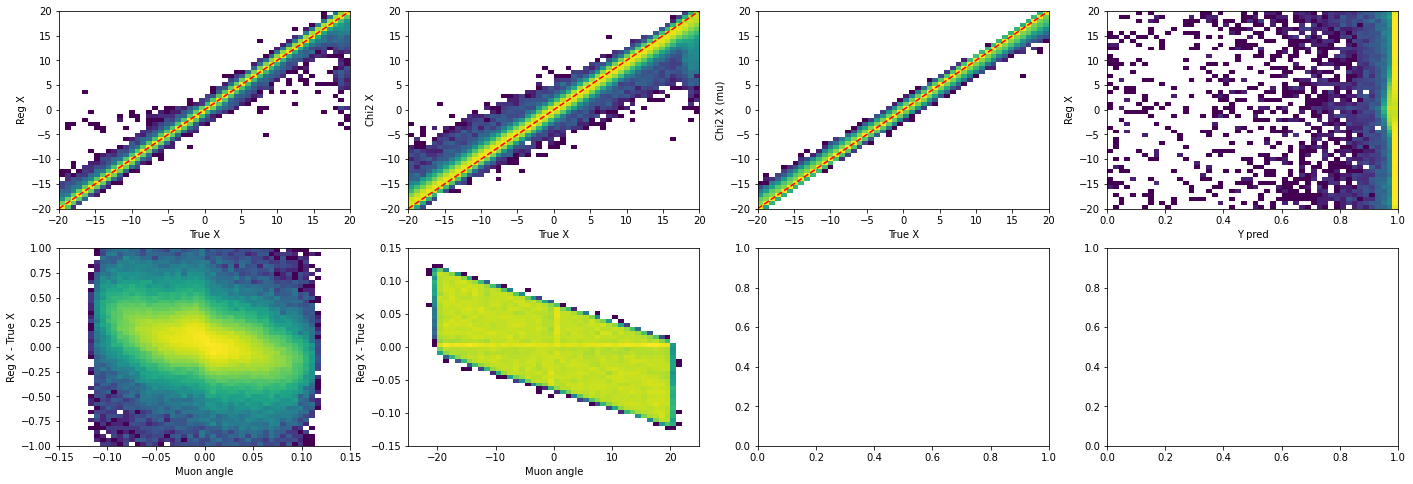

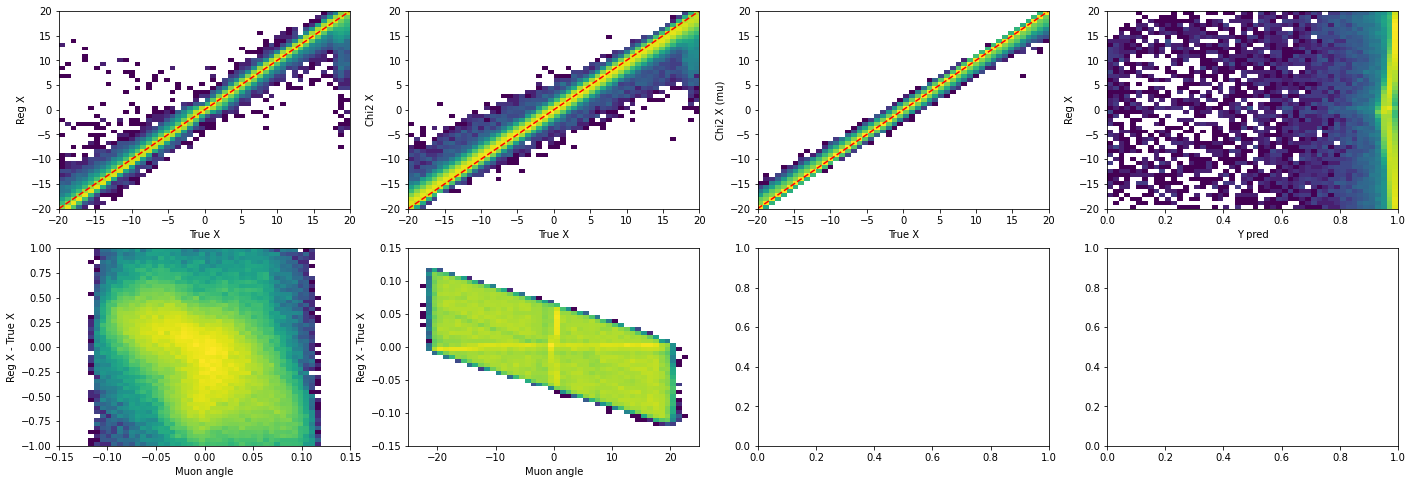

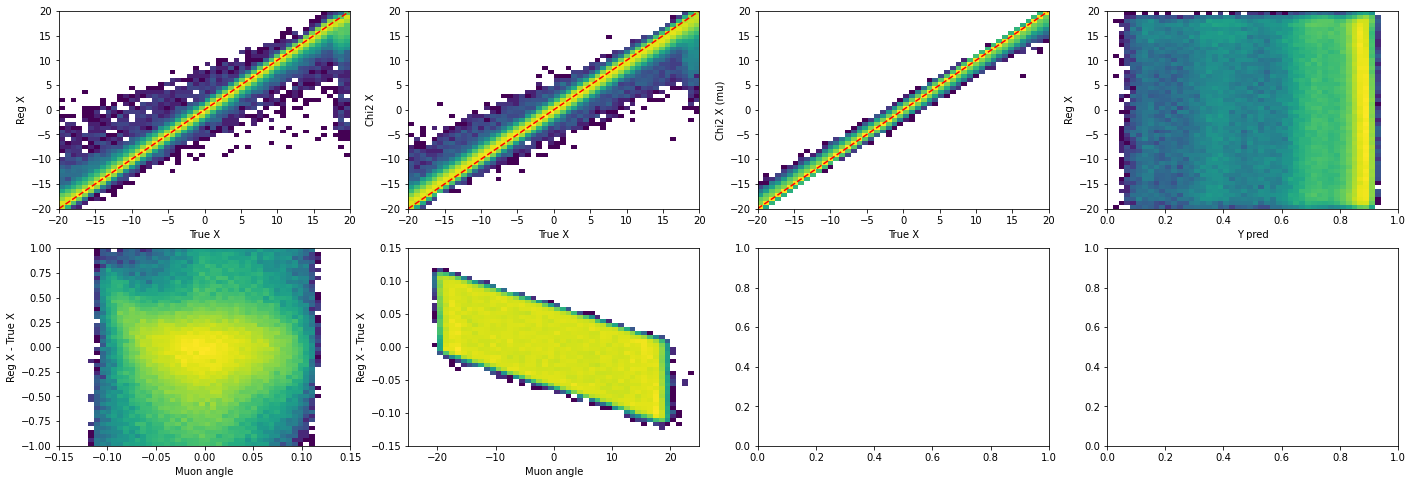

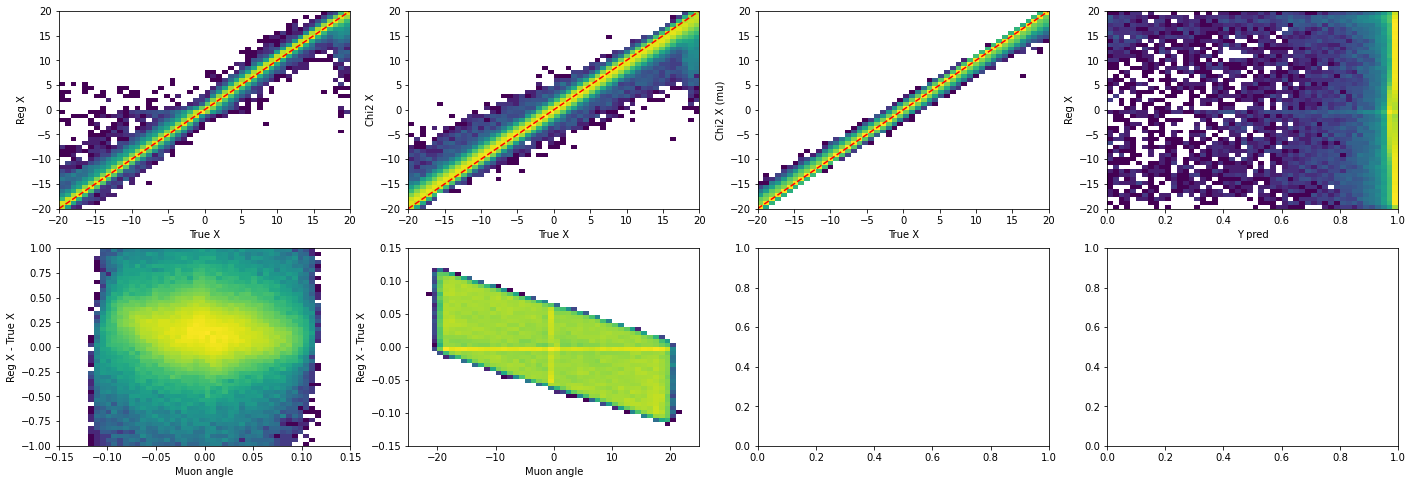

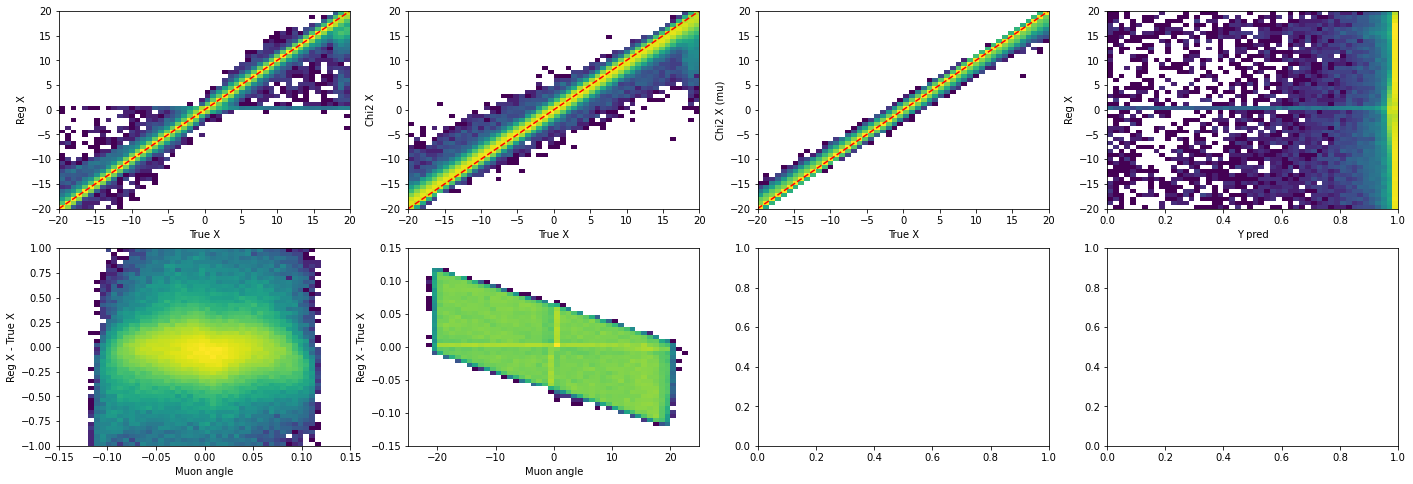

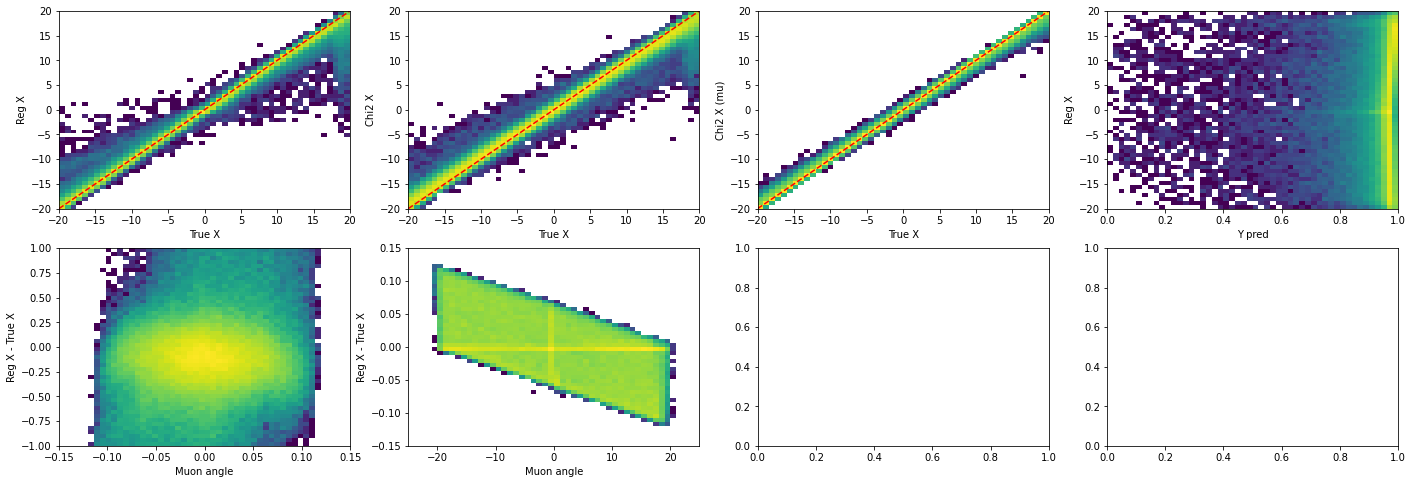

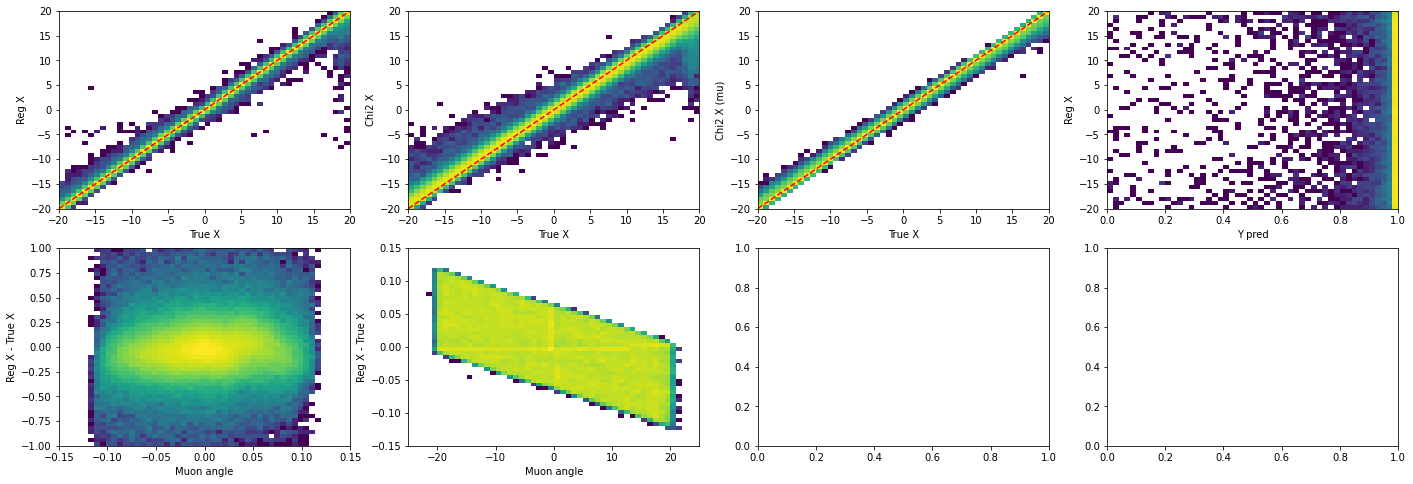

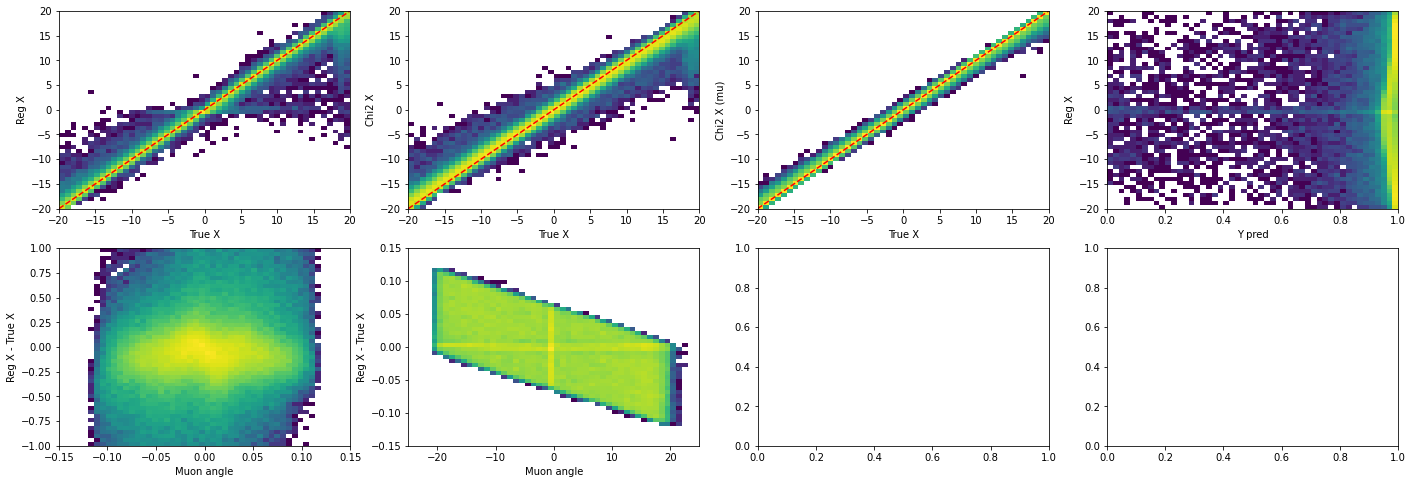

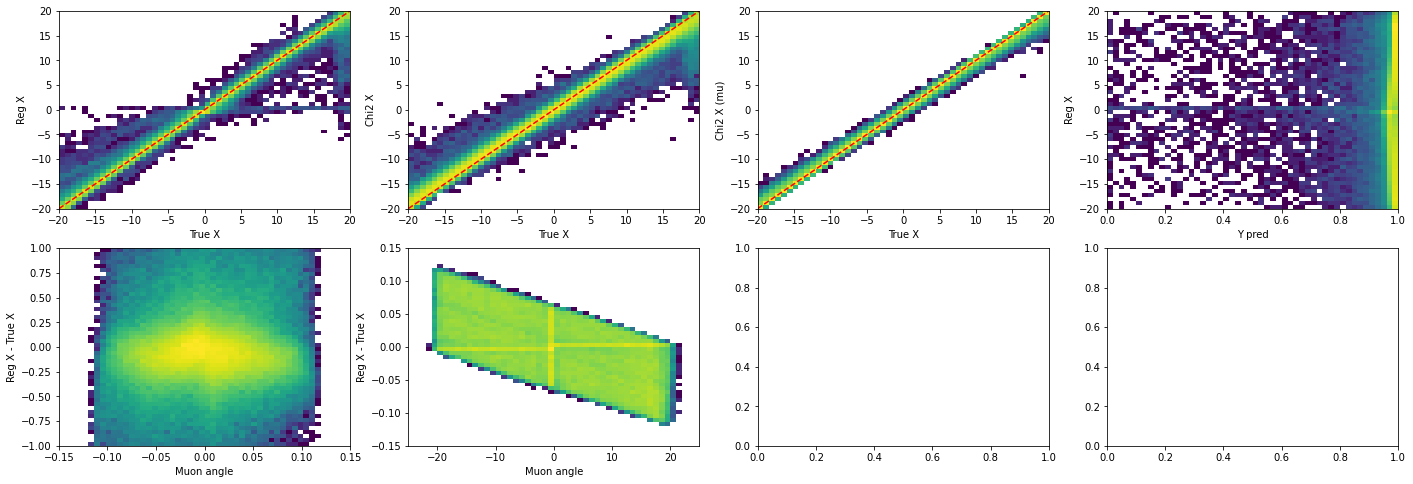

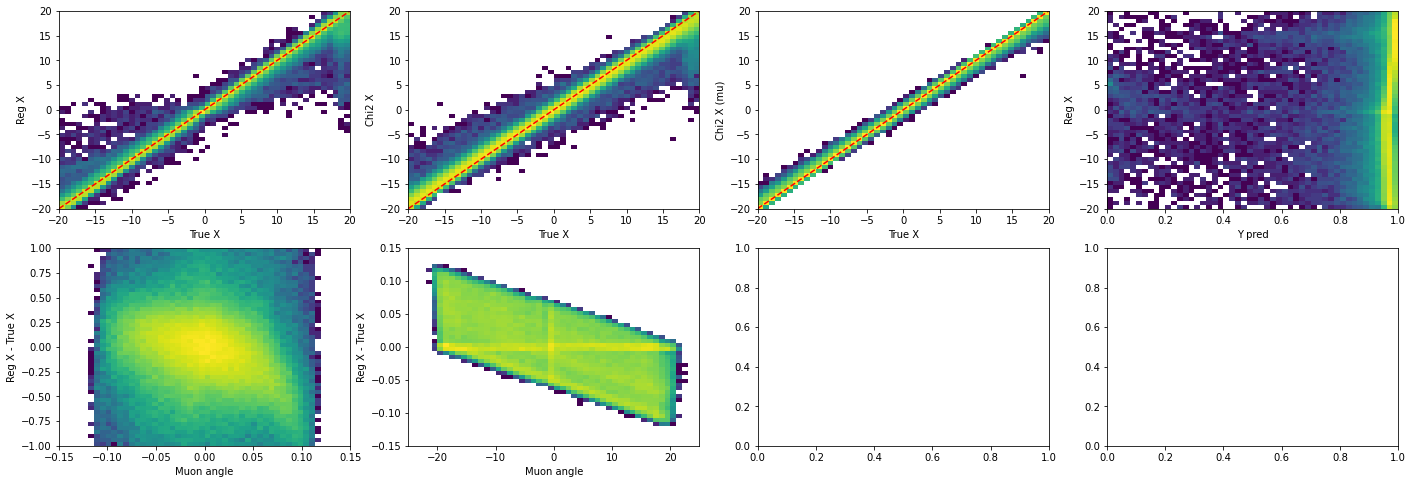

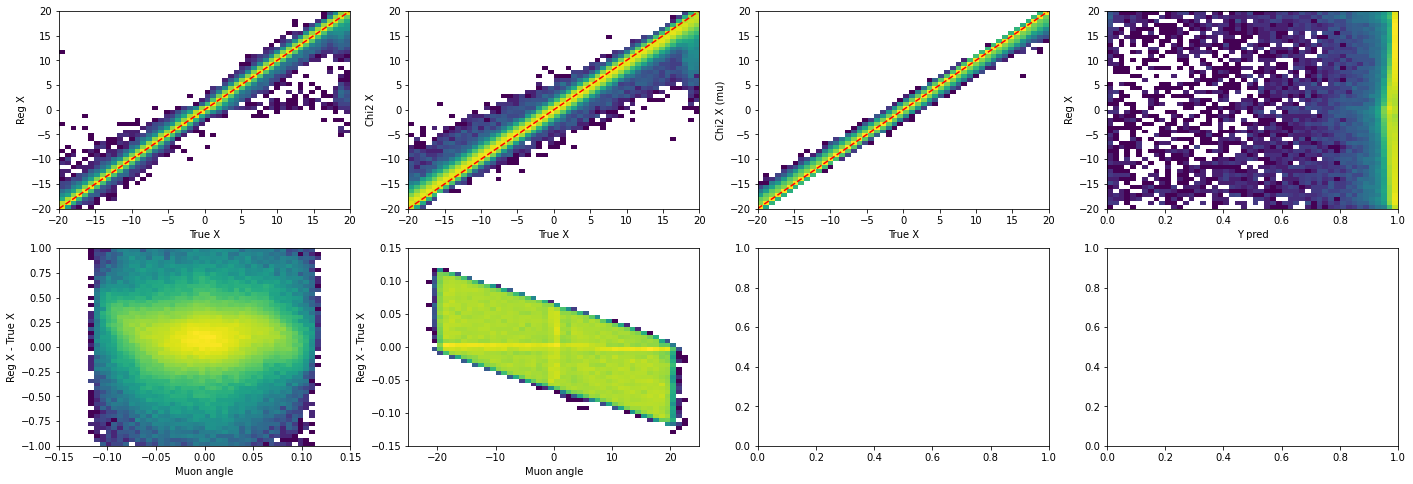

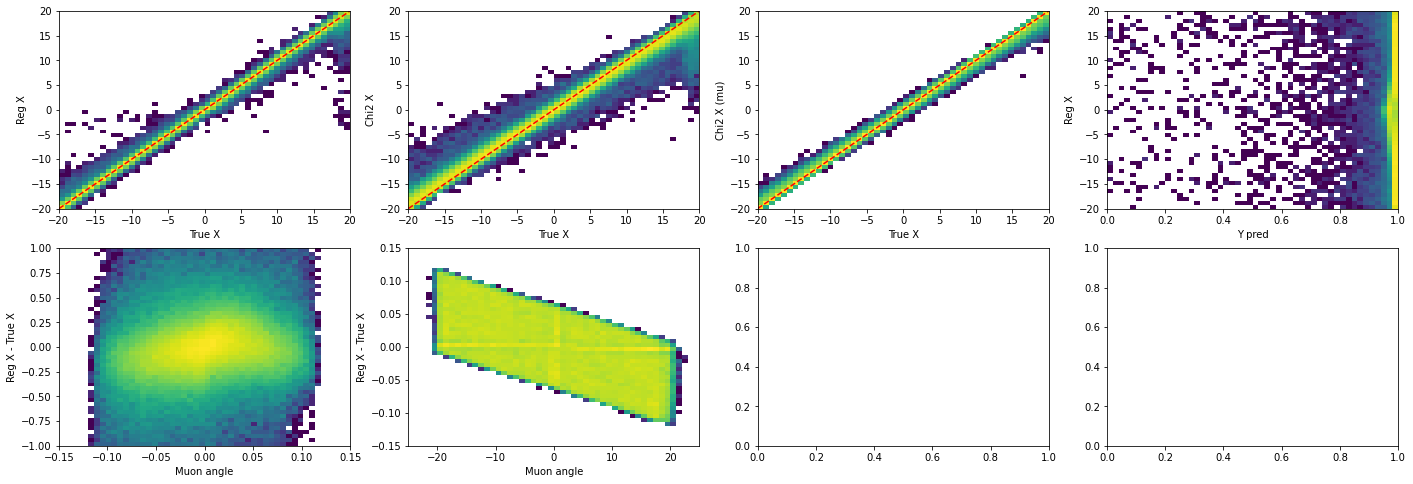

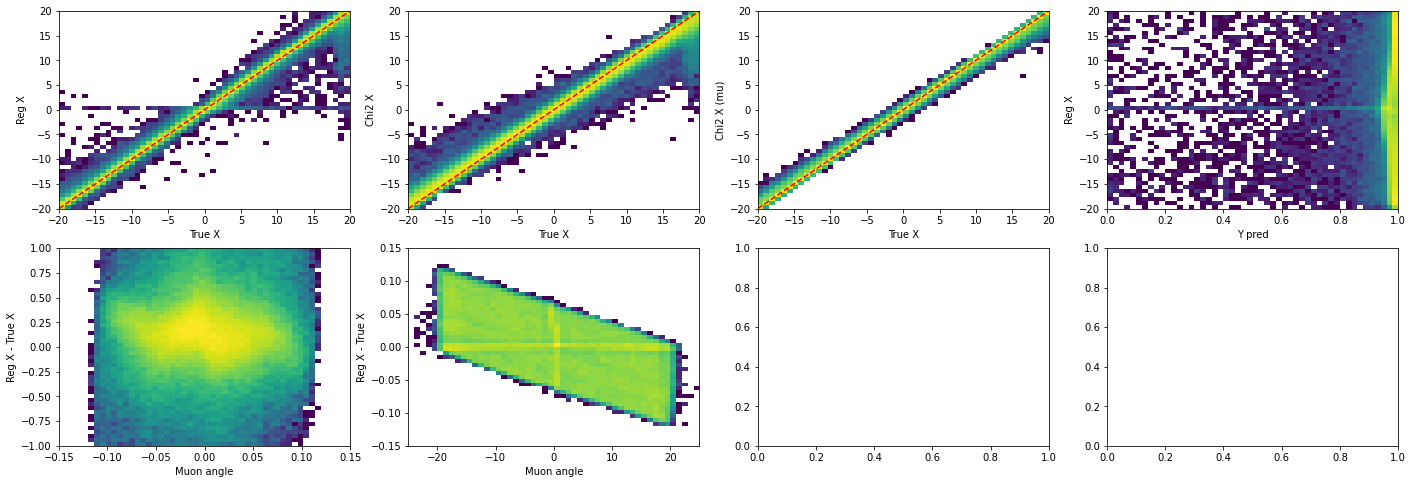

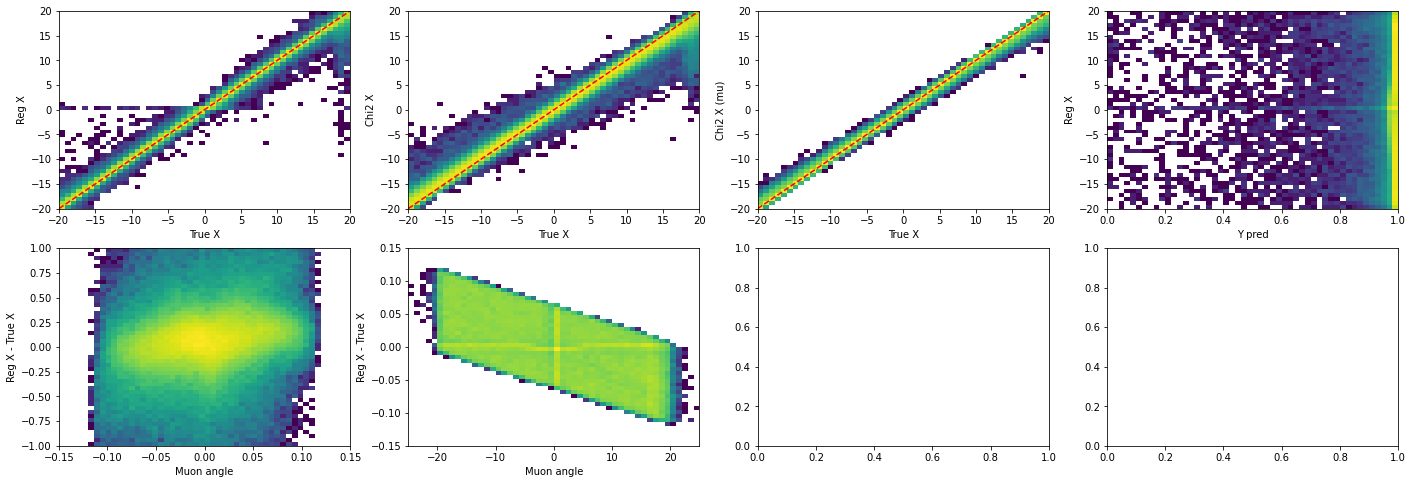

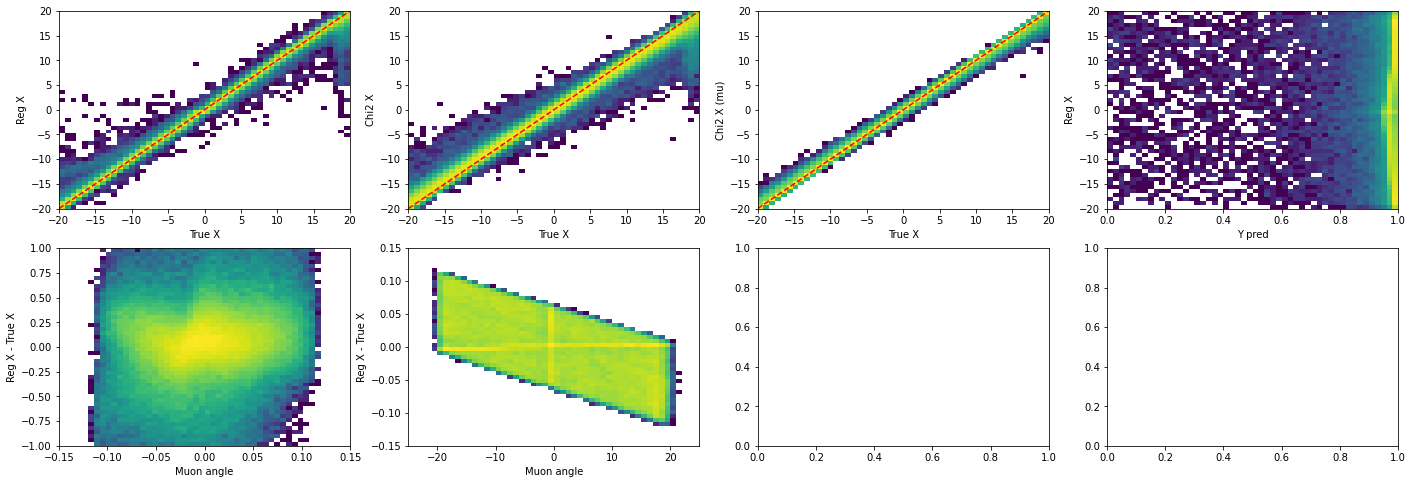

In [39]:
for mod in mdict:
    
    ncols, nrows = (4,2)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()

    
    this_cut=(Y_mu==1)
    
    axs[0].hist2d( data['ev_mu_x'][this_cut], 
                   mdict[mod]['x_reg'][this_cut], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[0].set_xlabel('True X')
    axs[0].set_ylabel('Reg X')
    axs[0].plot([-20,20],[-20,20], 'r--')
    
    axs[1].hist2d( data['ev_mu_x'][this_cut], 
                   lfits[this_cut][:,1], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[1].set_xlabel('True X')
    axs[1].set_ylabel('Chi2 X')
    axs[1].plot([-20,20],[-20,20], 'r--')
    
    axs[2].hist2d( data['ev_mu_x'][this_cut], 
                   lfits_mu[this_cut][:,1], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[2].set_xlabel('True X')
    axs[2].set_ylabel('Chi2 X (mu)')
    axs[2].plot([-20,20],[-20,20], 'r--')
    
    axs[3].hist2d(mdict[mod]['yhat'][this_cut], 
                  mdict[mod]['x_reg'][this_cut],
                  range=((0.0,1), (-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[3].set_xlabel('Y pred')
    axs[3].set_ylabel('Reg X')
    
    axs[4].hist2d(data['ev_mu_theta'][this_cut],
                  mdict[mod]['x_reg'][this_cut] - data['ev_mu_x'][this_cut], 
                  range=((-0.15, 0.15), (-1,1)),
                bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[4].set_xlabel('Muon angle')
    axs[4].set_ylabel('Reg X - True X')
    
    if 'a_reg' in mdict[mod]:
        
        axs[5].hist2d(mdict[mod]['x_reg'][this_cut],
                      mdict[mod]['a_reg'][this_cut], 
                      range=((-25,25), (-0.15,0.15)),
                    bins=(50,50),norm=mpl.colors.LogNorm() )
        axs[5].set_xlabel('Muon angle')
        axs[5].set_ylabel('Reg X - True X')
    
    plt.savefig(f"plots/{mod}_reg_2d.pdf")
    plt.show()